<a href="https://colab.research.google.com/github/apoorwagupta/Multiclass-Classification-of-Colorectal-Cancer-Tissue/blob/main/Inception_V3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.patches as patches
import random
from sklearn.utils import shuffle
from glob import glob
import seaborn as sns

import torch
import torchvision.models as models
from torchvision import datasets, transforms
from torch import optim
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data.sampler import SubsetRandomSampler
import random
from termcolor import colored
from sklearn.metrics import confusion_matrix
import itertools

from sklearn.model_selection import train_test_split
from tsne import bh_sne
import matplotlib.patches as patches
from PIL import Image
from matplotlib.colors import ListedColormap
from matplotlib.gridspec import GridSpec

In [ ]:
import zipfile
import os

zip_ref = zipfile.ZipFile('/content/drive/MyDrive/cancerhistologydataset.zip', 'r') #Opens the zip file in read mode
zip_ref.extractall('/base_dir') #Extracts the files into the /base_dir folder
zip_ref.close()

In [ ]:
base_dir = '/base_dir/Kather_texture_2016_image_tiles_5000/Kather_texture_2016_image_tiles_5000'

In [ ]:
## Get labels of all classes in this dataset
img_labels = [i for i in os.listdir(base_dir) if not i.startswith('.')]
print('There are {} classes in this dataset:\n{}'.format(len(img_labels), img_labels))

There are 8 classes in this dataset:
['01_TUMOR', '02_STROMA', '03_COMPLEX', '04_LYMPHO', '05_DEBRIS', '06_MUCOSA', '07_ADIPOSE', '08_EMPTY']


In [ ]:
tumor_files = glob(os.path.join(base_dir, img_labels[0], '*.tif'))
stroma_files = glob(os.path.join(base_dir, img_labels[1], '*.tif'))
complex_files = glob(os.path.join(base_dir, img_labels[2], '*.tif'))
lympho_files = glob(os.path.join(base_dir, img_labels[3], '*.tif'))
debris_files = glob(os.path.join(base_dir, img_labels[4], '*.tif'))
mucosa_files = glob(os.path.join(base_dir, img_labels[5], '*.tif'))
adipose_files = glob(os.path.join(base_dir, img_labels[6], '*.tif'))
empty_files = glob(os.path.join(base_dir, img_labels[7], '*.tif'))
img_files = [tumor_files, stroma_files, complex_files, lympho_files, debris_files, mucosa_files, adipose_files, empty_files]
total_files = [img for folder in img_files for img in folder]

In [ ]:
print('Total number of images in this dataset: {}'.format(len(total_files)))
print ('-'*50)
for i in np.arange(8):
    print('Number of images for {} category: {}'.format(img_labels[i].split('_')[1], len(img_files[i])))

Total number of images in this dataset: 5000
--------------------------------------------------
Number of images for TUMOR category: 625
Number of images for STROMA category: 625
Number of images for COMPLEX category: 625
Number of images for LYMPHO category: 625
Number of images for DEBRIS category: 625
Number of images for MUCOSA category: 625
Number of images for ADIPOSE category: 625
Number of images for EMPTY category: 625


In [ ]:
img = readImage_rgb(img_files[0][0])
print(img.shape)

(150, 150, 3)


### The Dataset
1.There are 5000 images evenly distributed in 8 classes with 625 images per class

2.multiclass classification:

  * 01_TUMOR -- Tumour epithelium
  * 02_STROMA -- Simple stroma(homogeneous composition, includes tumour    stroma, extra-tumoural stroma and smooth muscle)


  * 03_COMPLEX -- Complex stroma (containing single tumour cells and/or few immune cells)
  
  * 04_LYMPHO -- Immune cells (including immune-cell conglomerates and sub-mucosal lymphoid follicles)
  
  * 05_DEBRIS -- Debris (including necrosis, hemorrhage and mucus)
  
  * 06_MUCOSA -- Normal mucosal glands
  
  * 07_ADIPOSE -- Adipose tissue
  
  * 08_EMPTY -- Background (no tissue)

3.Image size: 150x150px, RGB mode

reference: https://www.nature.com/articles/srep27988

### Visualising images

First, we can view several images from each class

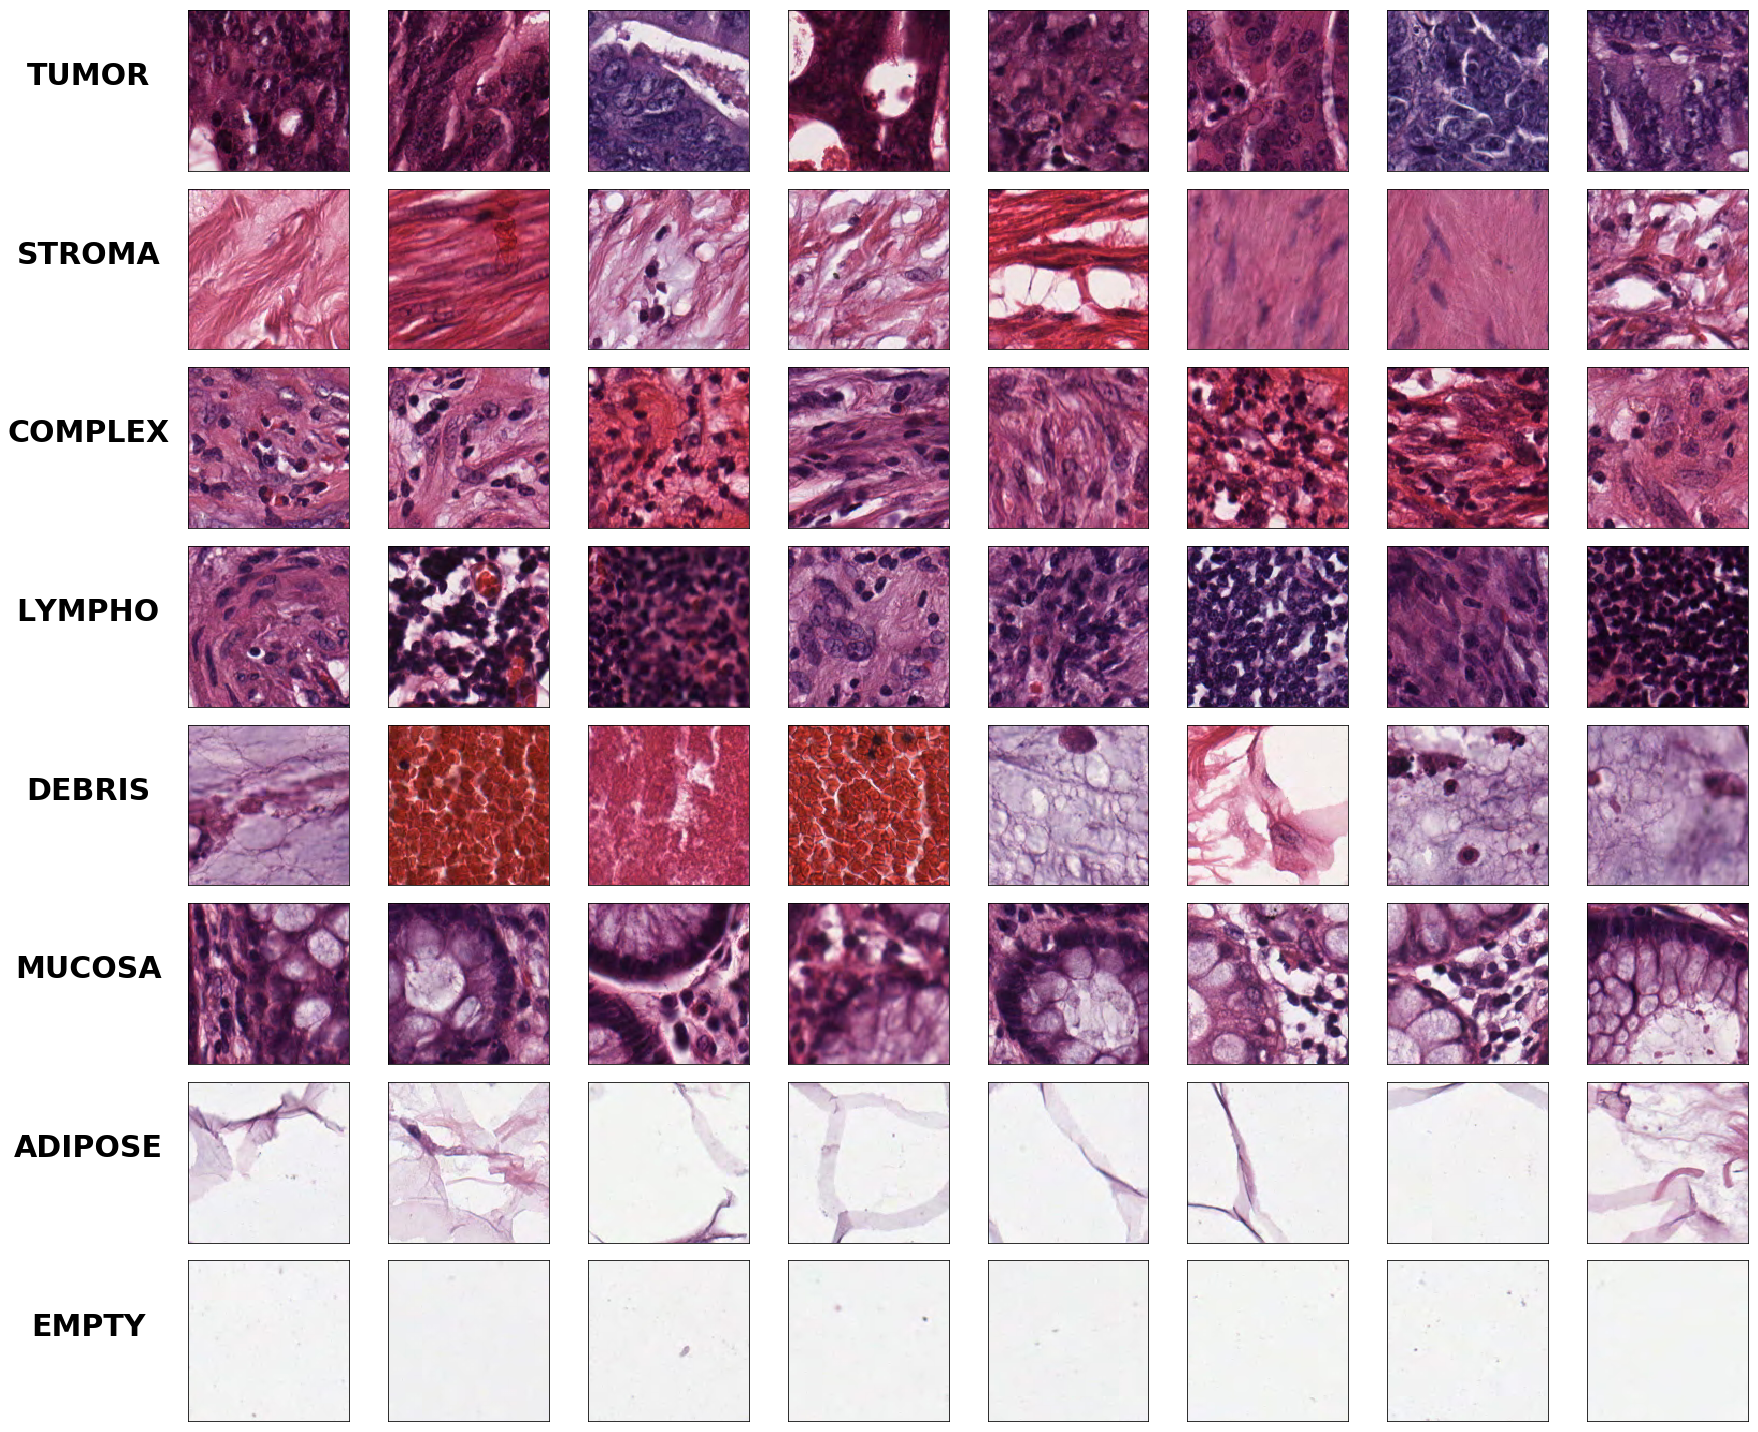

In [ ]:
def plotImage_cat(img_files, img_labels):
    fig = plt.figure(figsize=(25,20))
    for i in np.arange(len(img_labels)):
        img_paths = img_files[i]
        img_label = img_labels[i]
        np.random.shuffle(img_paths)
        img_paths = img_paths[:8]
        for j, img_path in enumerate(img_paths):
            fig.add_subplot(8,8,i*8+j+1, xticks = [], yticks = [])
            plt.imshow(readImage_rgb(img_path))
            if j == 0:
                plt.ylabel(img_label.split('_')[1], rotation = 0, labelpad=100, fontsize=30, fontweight = 'bold')
    plt.tight_layout()    
    #fig.savefig('Histology.png')
plotImage_cat(img_files, img_labels)

Next, we can view individual image in each channel (RGB: red/green/blue) separately and in RGB mode

In [ ]:
def plotImage_rgb(img_paths, img_label):
    '''Plot image in each of RGB (red/green/blue) channels separately and in RGB mode'''
    np.random.shuffle(img_paths)
    img_path = img_paths[0]
    img_rgb = readImage_rgb(img_path)
     
    fig = plt.figure(figsize=(20,8))
    channels = ['Red', 'Green', 'Blue']
    color = ['r','g','b']
    
    for idx in np.arange(3):
        plt.subplot(1,4,idx+1)
        img = img_rgb[:,:,idx]
        plt.imshow(img, cmap = 'gray')
        plt.title(channels[idx], color = color[idx], fontsize = 30)
        
    plt.subplot(1,4,4)
    plt.imshow(img_rgb)
    plt.title('RGB', fontsize = 30)
    fig.suptitle('H&E image of {} area'.format(img_label), fontsize = 36) 
    
    plt.tight_layout()

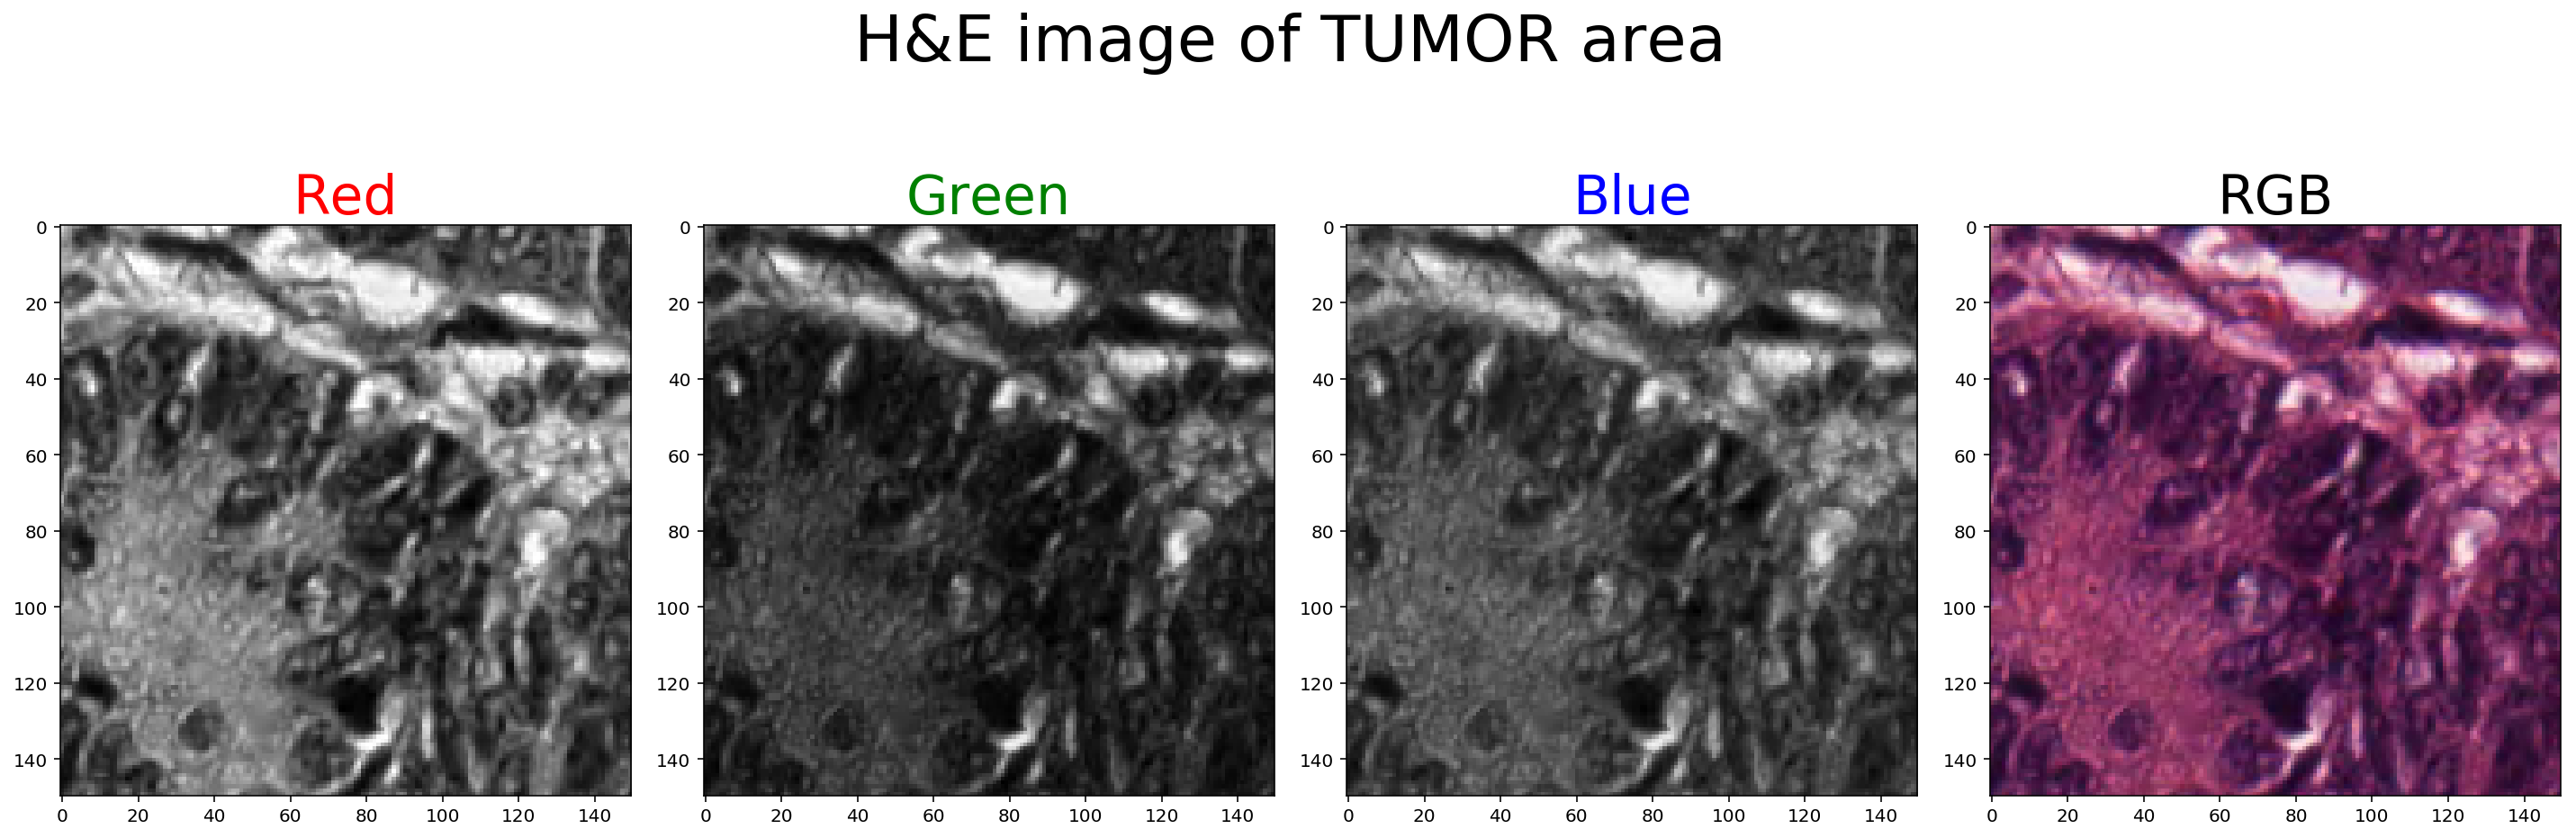

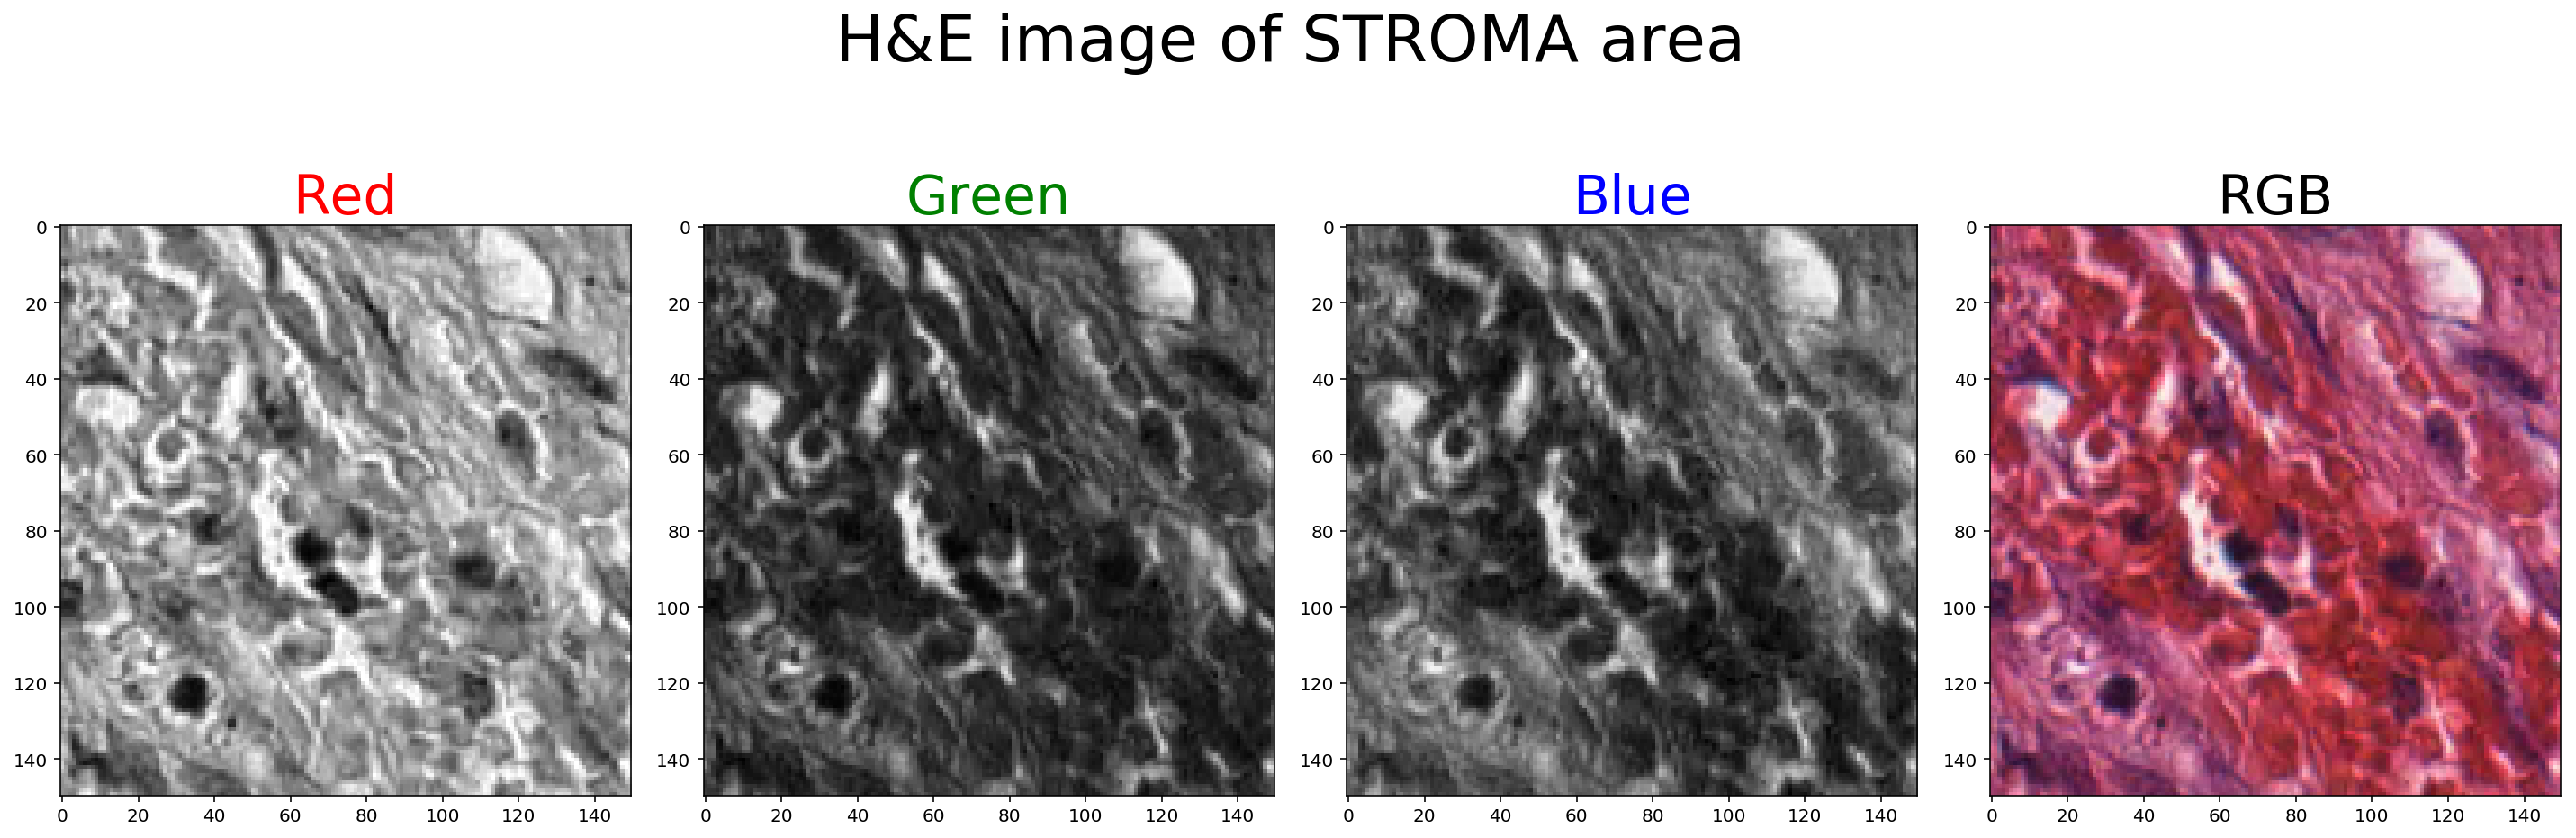

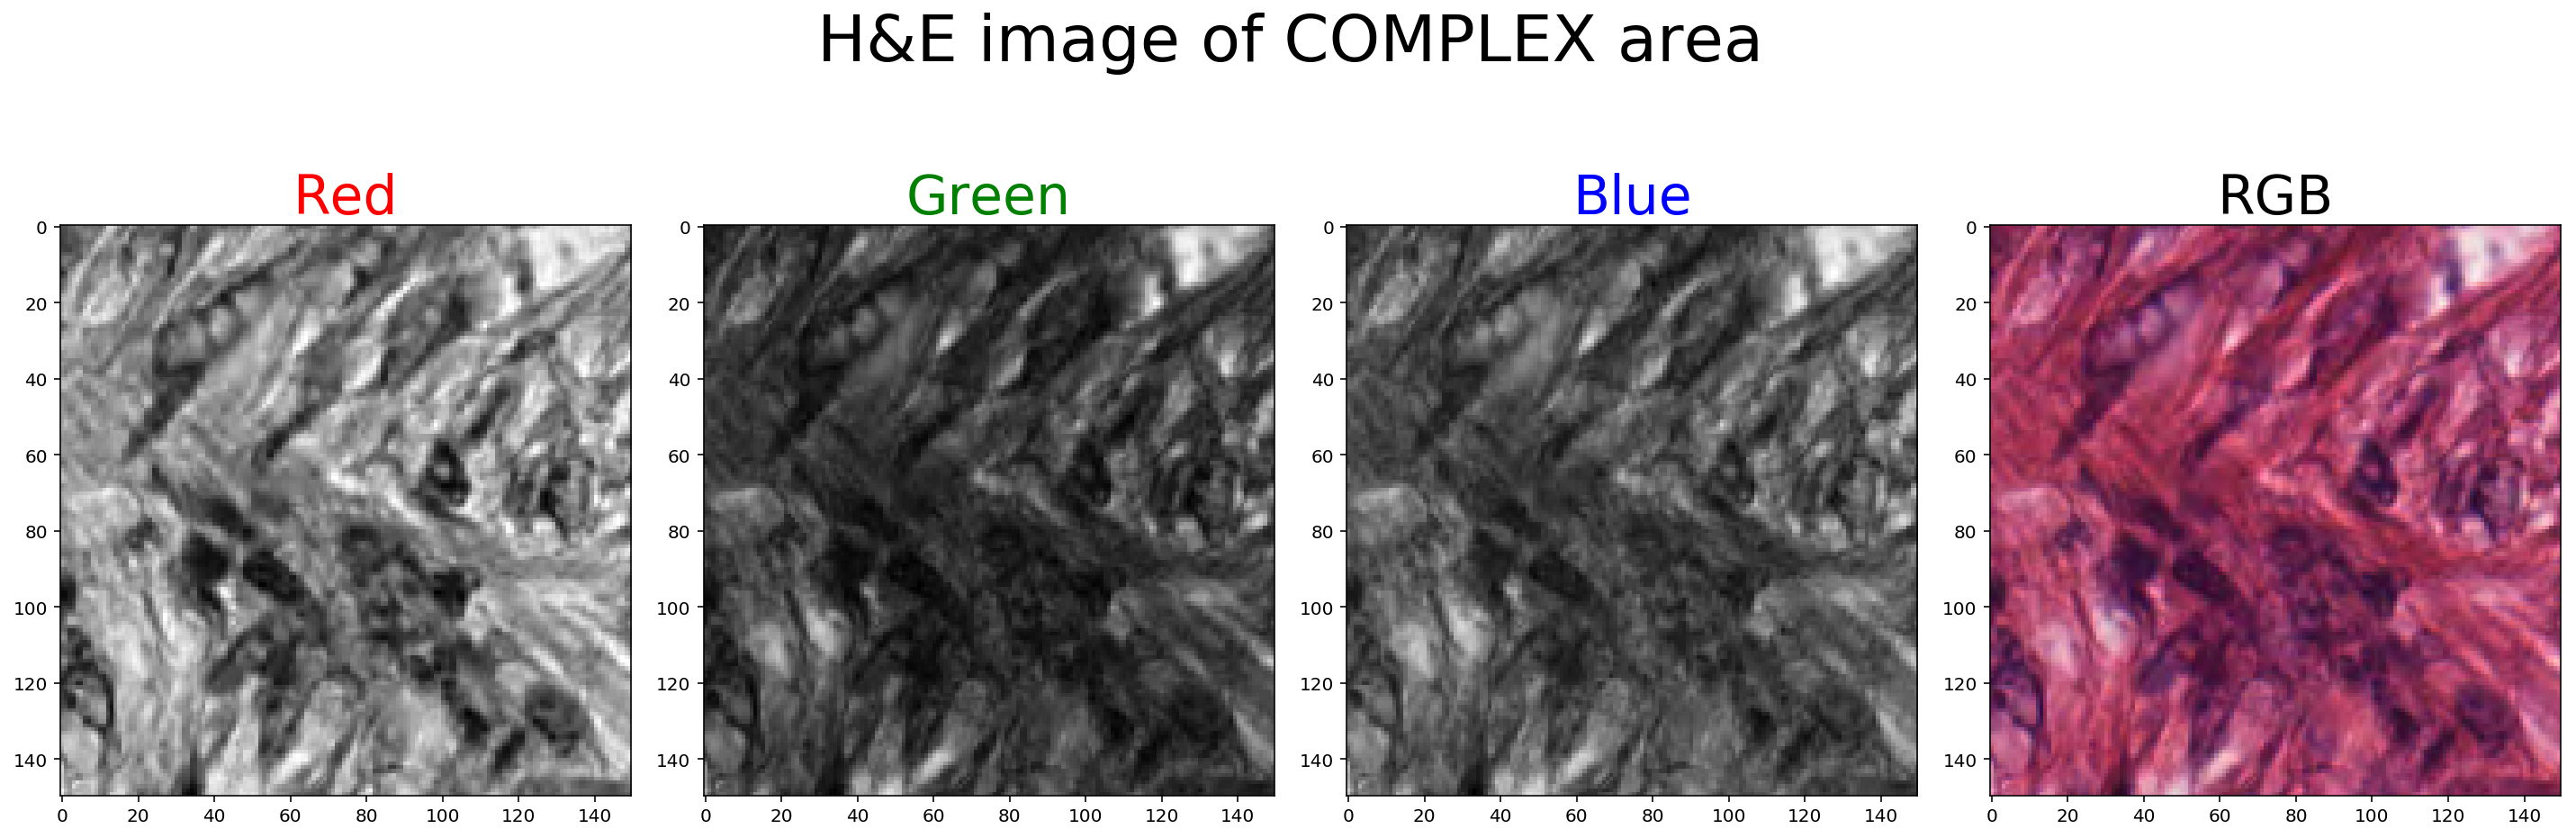

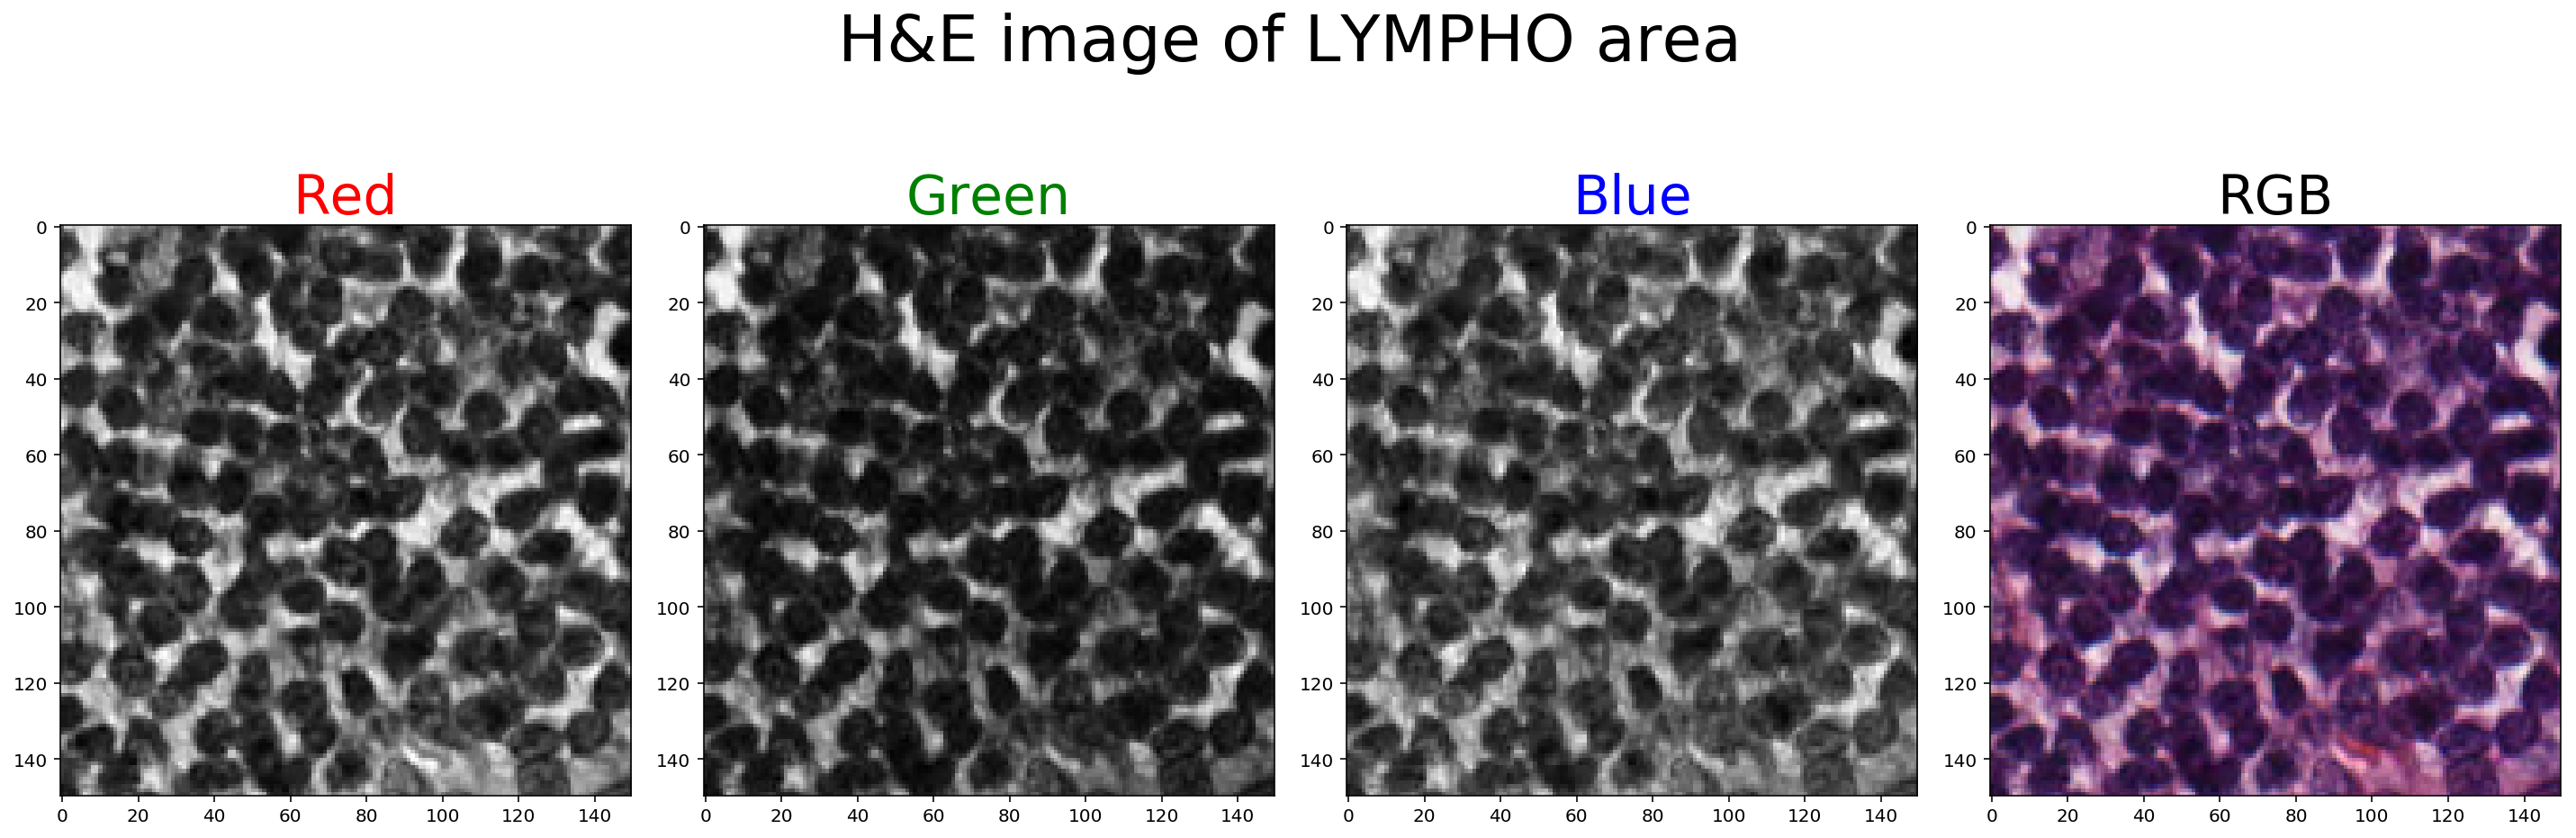

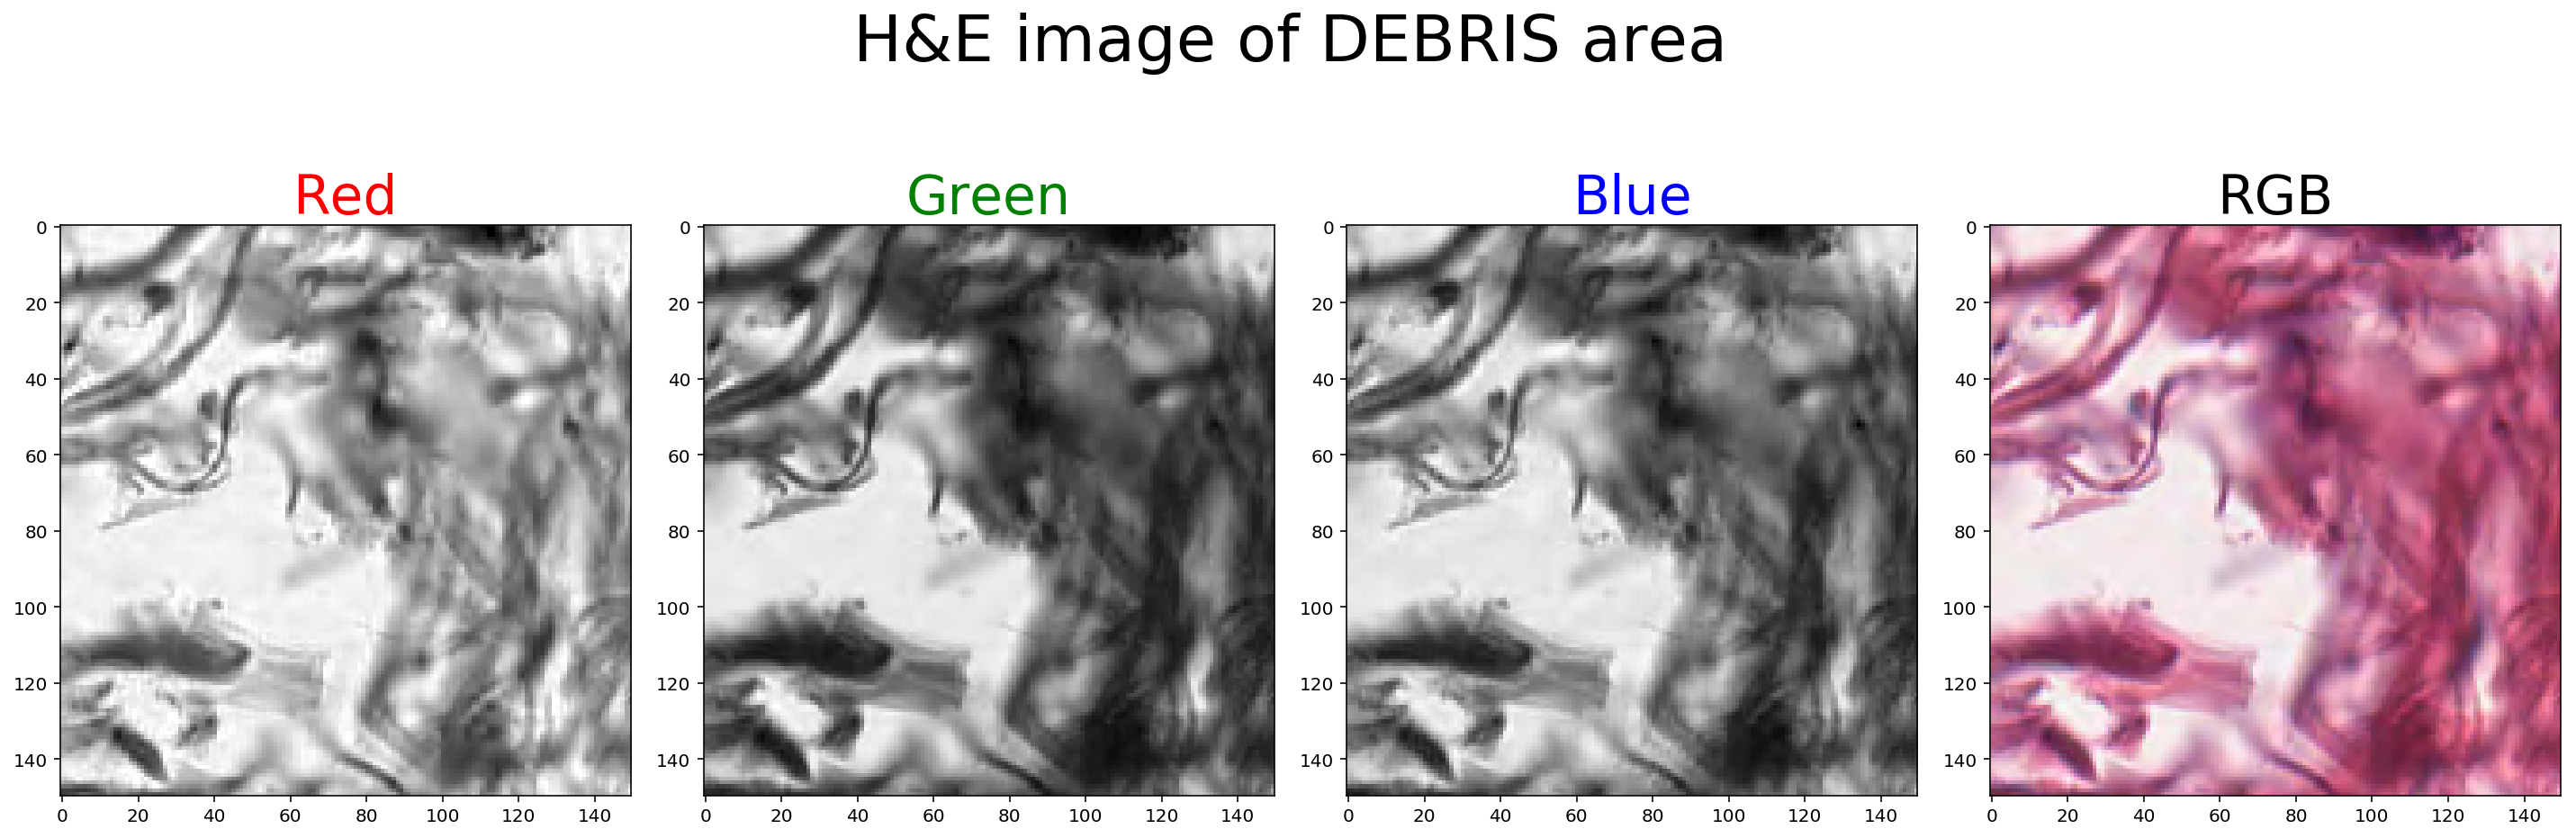

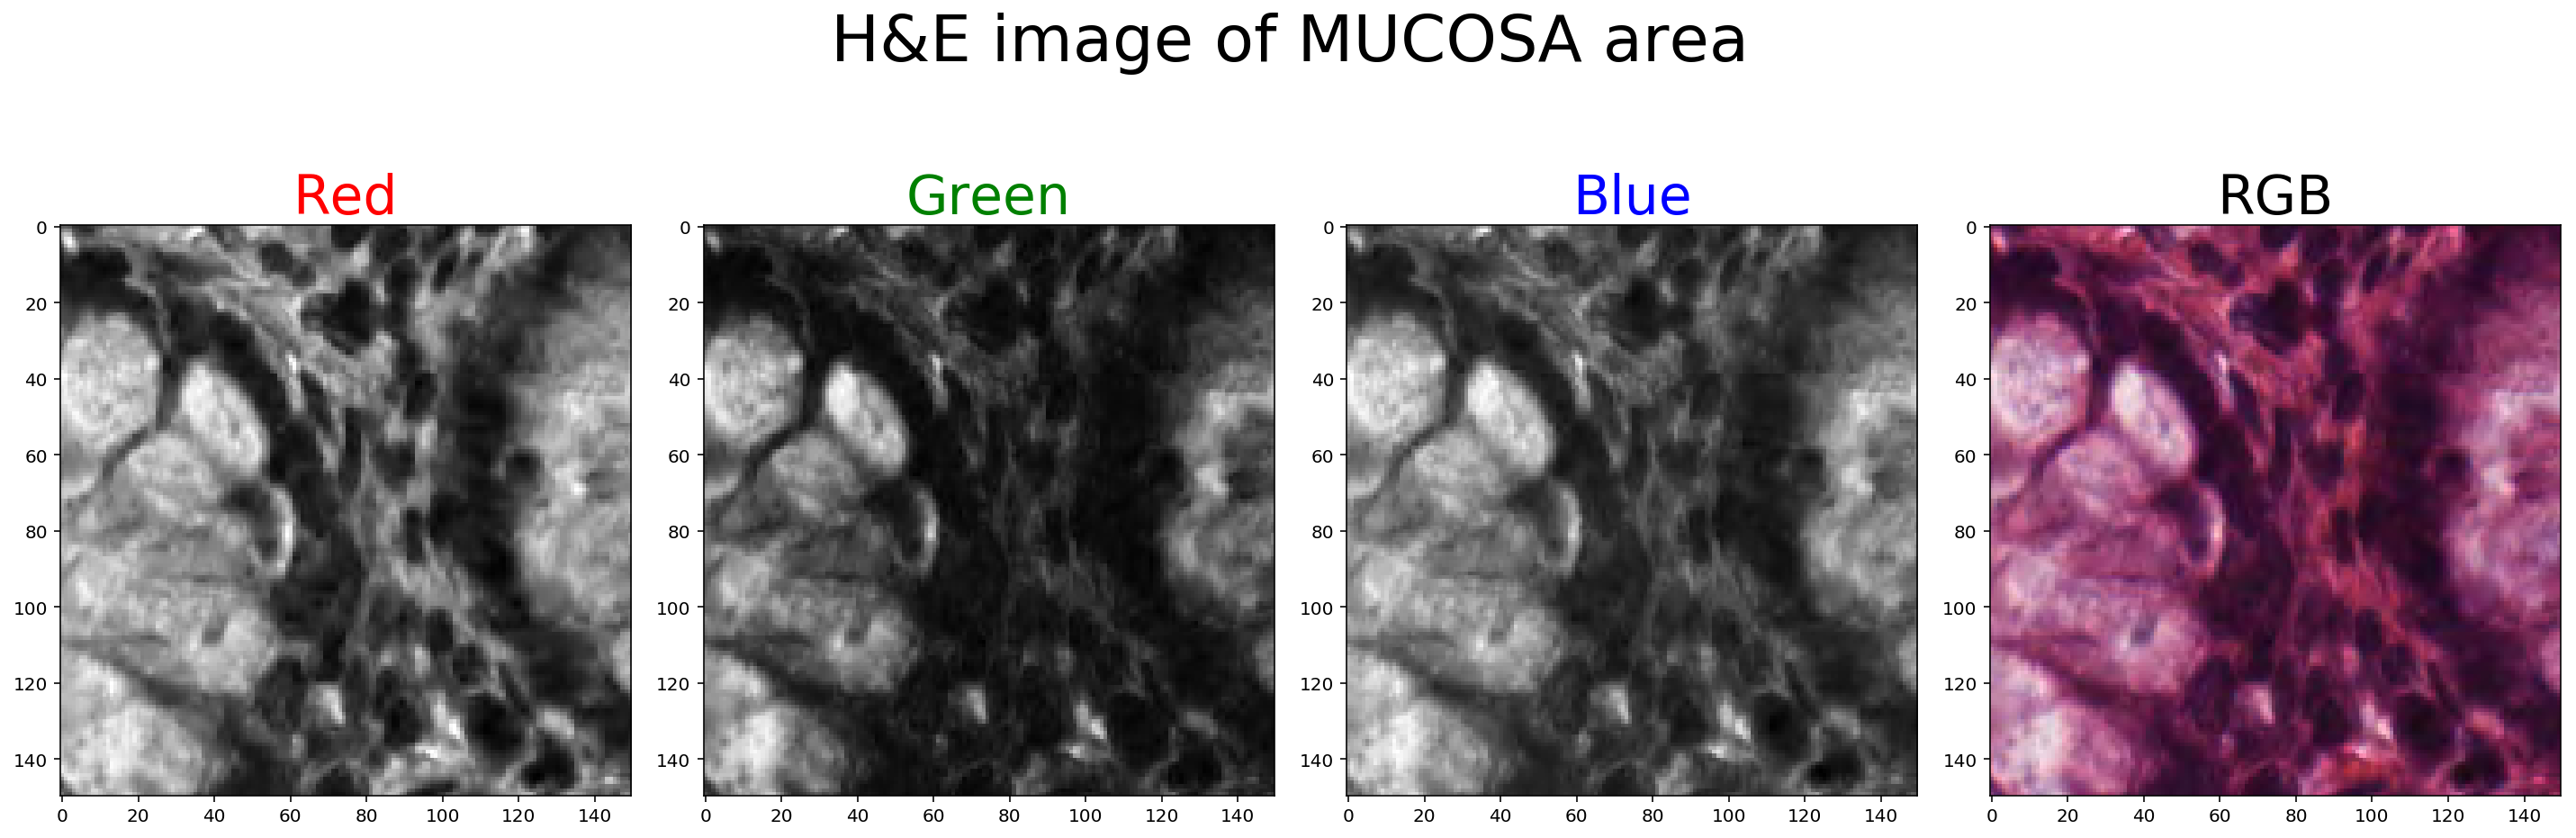

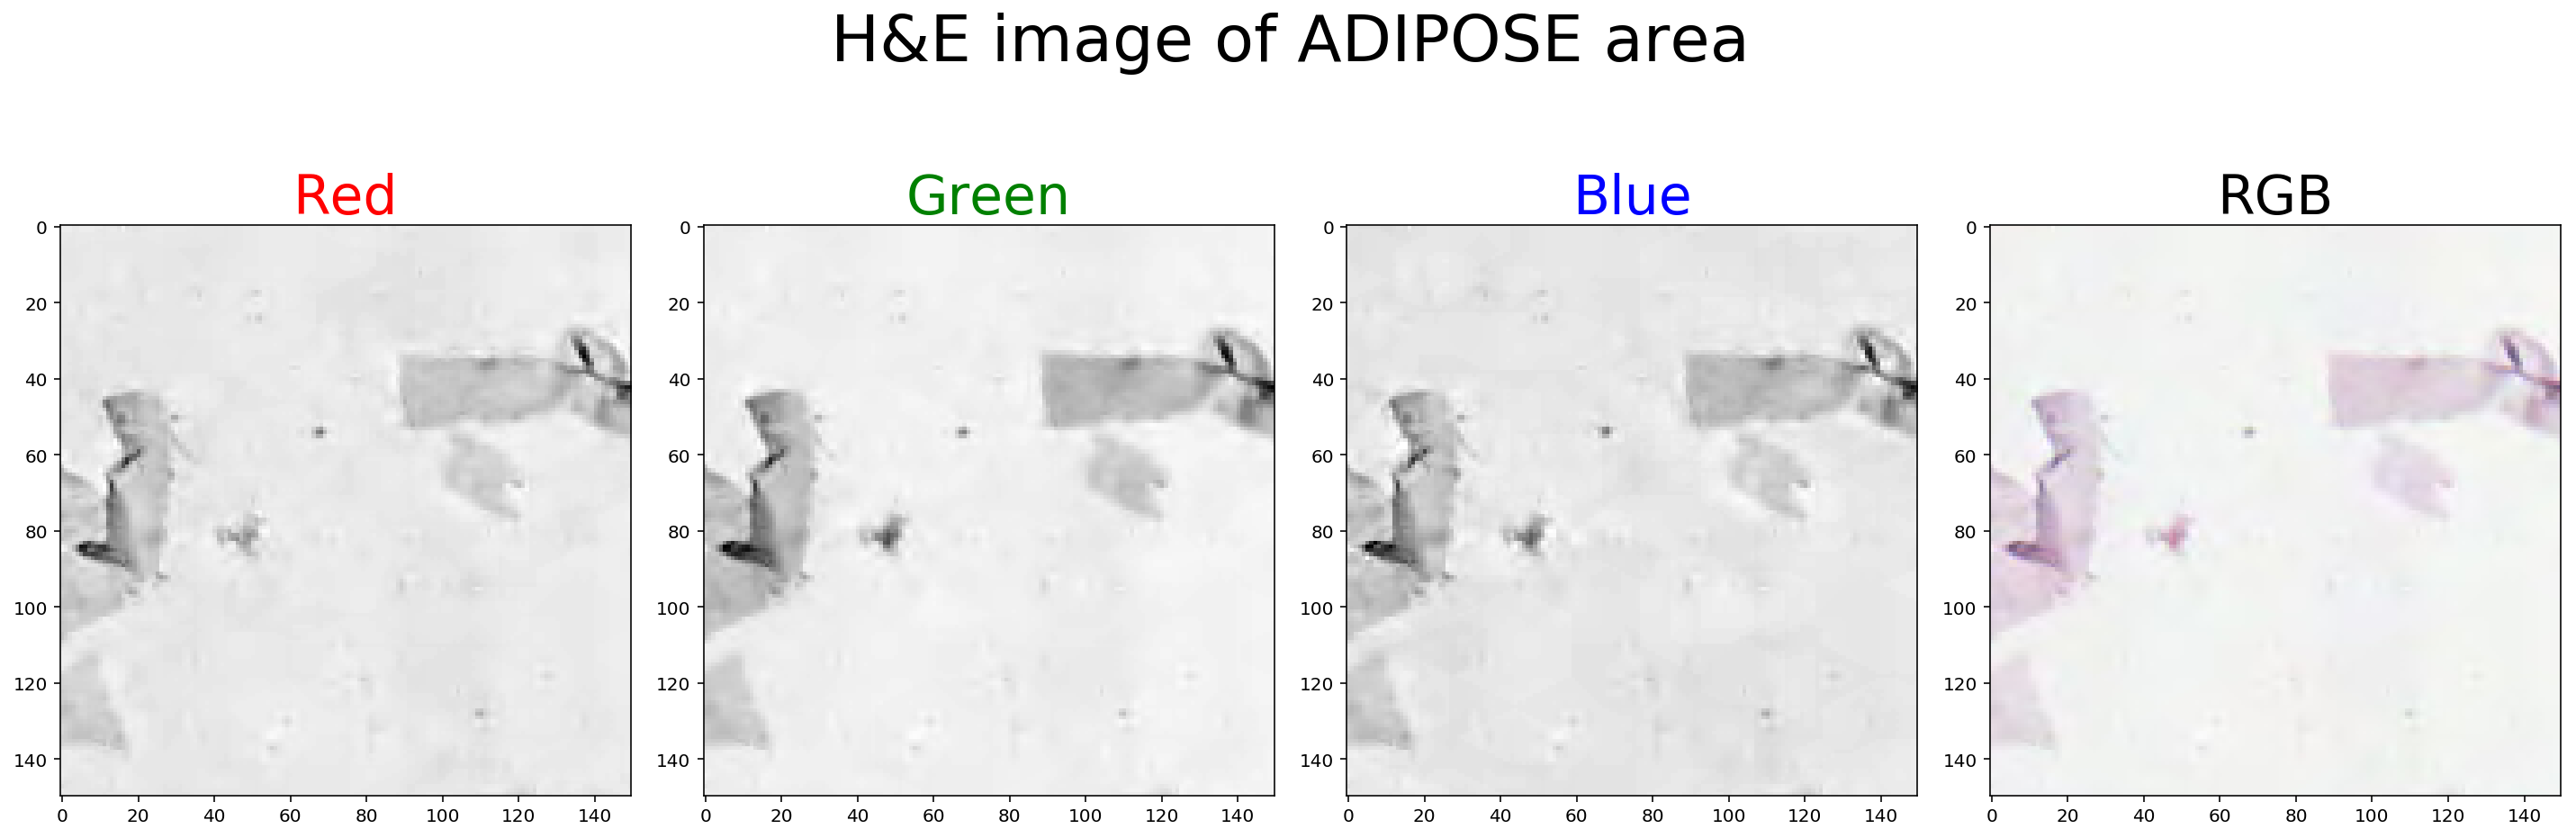

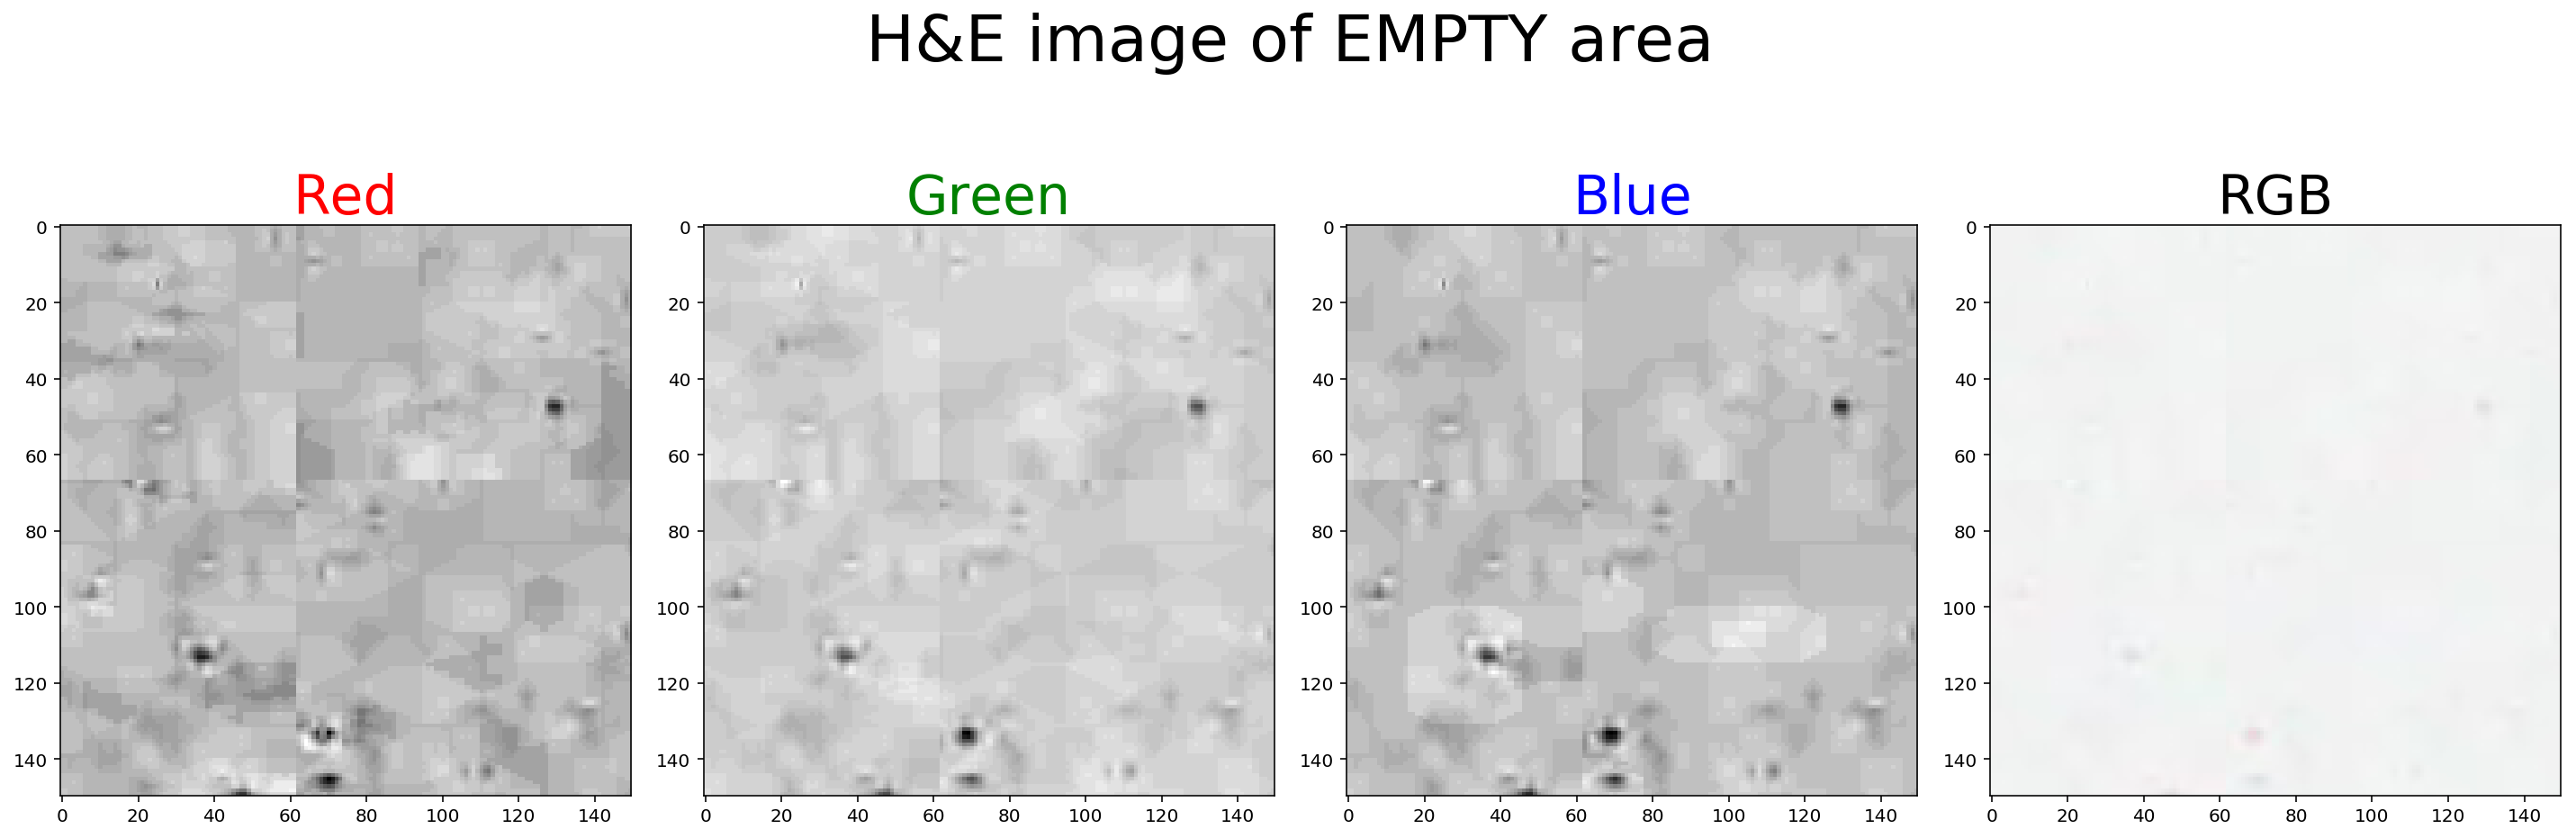

In [ ]:
for i in np.arange(8):
    plotImage_rgb(img_files[i], img_labels[i].split('_')[1])

### Basic image pixel statistics

Lower-order statistics such as the mean and variance of image pixel intensity can be used to describe texture. To analyze these statistics, the maximum, minimum, mean values and standard deviation of pixel intensity for each image is computed.

In [ ]:
def image_summary(image_paths, img_label):
    img_dict = {}
    for i in range(len(image_paths)):
        img_path = image_paths[i]
        img_dict[img_path] = {}
        img = cv2.imread(img_path)
        img_dict[img_path]['label'] = img_label
        img_dict[img_path]['max'] = img.max()
        img_dict[img_path]['min'] = img.min()
        
        channel_mean = img.mean(axis = (0,1), keepdims = True).squeeze()
        channel_std = img.std(axis = (0,1), keepdims = True).squeeze()
        channel_q01 = np.quantile(img, 0.1, axis=(0,1), keepdims=True).squeeze()
        channel_q09 = np.quantile(img, 0.9, axis=(0,1), keepdims=True).squeeze()
        img_dict[img_path]['red_mean'], img_dict[img_path]['green_mean'], img_dict[img_path]['blue_mean'] = channel_mean
        img_dict[img_path]['red_std'], img_dict[img_path]['green_std'], img_dict[img_path]['blue_std'] = channel_std
        img_dict[img_path]['red_q01'], img_dict[img_path]['green_q01'], img_dict[img_path]['blue_q01'] = channel_q01
        img_dict[img_path]['red_q09'], img_dict[img_path]['green_q09'], img_dict[img_path]['blue_q09'] = channel_q09
        
    img_df = pd.DataFrame.from_dict(img_dict, orient = 'index')
    return img_df

In [ ]:
tumor_files_df = image_summary(tumor_files, 'TUMOR')
stroma_files_df = image_summary(stroma_files, 'STROMA')
complex_files_df = image_summary(complex_files, 'COMPLEX')
lympho_files_df = image_summary(lympho_files, 'LYMPHO')
debris_files_df = image_summary(debris_files, 'DEBRIS')
mucosa_files_df = image_summary(mucosa_files, 'MUCOSA')
adipose_files_df = image_summary(adipose_files, 'ADIPOSE')
empty_files_df = image_summary(empty_files, 'EMPTY')

In [ ]:
pixel_df = pd.concat([tumor_files_df, stroma_files_df, complex_files_df, lympho_files_df, debris_files_df, mucosa_files_df, adipose_files_df, empty_files_df])
pixel_df.shape

(5000, 15)

In [ ]:
pixel_df.to_csv('Colorectal_histology_mnist_pixel_df.csv', index_label = 'img_id')
pixel_df = pd.read_csv('Colorectal_histology_mnist_pixel_df.csv', index_col = 'img_id')

In [ ]:
pixel_df.describe()

max          min     red_mean   green_mean    blue_mean  \
count  5000.000000  5000.000000  5000.000000  5000.000000  5000.000000   
mean    253.738400    33.073000   149.021602   120.444890   165.724198   
std       4.755638    58.167228    57.698439    72.193794    51.263512   
min     190.000000     0.000000    38.260711    19.504400    53.743022   
25%     255.000000     2.000000   105.316689    64.500989   124.760700   
50%     255.000000     7.000000   131.465133    92.044844   160.190644   
75%     255.000000    27.000000   211.379856   197.407267   216.681911   
max     255.000000   234.000000   243.896844   244.455778   243.653289   

           red_std    green_std     blue_std      red_q01    green_q01  \
count  5000.000000  5000.000000  5000.000000  5000.000000  5000.000000   
mean     32.687364    37.394919    36.259577   111.733600    80.722960   
std      16.364589    19.016687    17.776395    69.682041    82.299805   
min       0.971972     0.888076     0.896202    17.000000     5.000000   
25%      23.477048    26.438023    25.983057    61.000000    21.000000   
50%      34.453753    38.824807    39.725139    82.000000    39.000000   
75%      44.985158    51.347413    49.031516   168.000000   134.000000   
max      84.855213    97.188613    81.882078   242.000000   243.000000   

          blue_q01      red_q09    green_q09     blue_q09  
count  5000.000000  5000.000000  5000.000000  5000.000000  
mean    120.485220   192.686980   170.245340   212.302240  
std      70.133412    44.975819    61.050057    31.717389  
min      24.000000    63.000000    31.000000    99.000000  
25%      58.000000   156.750000   117.000000   192.750000  
50%     104.000000   200.000000   174.000000   218.000000  
75%     173.000000   241.000000   239.000000   243.000000  
max     242.000000   247.000000   247.000000   248.000000

### Image pre-processing and data loading

Before training the model, first we need to split the dataset into training, validation and test datasets.We use the split ratio of 0.7/0.15/0.15 for train/val/test and randomly assign each image to one of the three datasets.

We use `SubsetRandomSampler` from `torch.utils.data.sampler` to stratify images.

In [ ]:
train_val_test_df = pixel_df.copy()

In [ ]:
total_num = train_val_test_df.shape[0]
split1 = int(total_num*0.7)
split2 = int(total_num*0.85)
indices = np.arange(total_num)

np.random.seed(123)
np.random.shuffle(indices)
train_idx, val_idx, test_idx = indices[:split1], indices[split1:split2], indices[split2:]

In [ ]:
train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)
test_sampler = SubsetRandomSampler(test_idx)

In [ ]:
train_transforms = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(144),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])
])

In [ ]:
BATCH_SIZE = 32
train_path = base_dir
train_data = datasets.ImageFolder(train_path, transform = train_transforms)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, sampler = train_sampler)
val_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, sampler = val_sampler)
test_loader = torch.utils.data.DataLoader(train_data, batch_size = BATCH_SIZE, sampler = test_sampler)

print('Number of images in training set: {}'.format(len(train_loader.sampler)))
print('Number of images in validation set: {}'.format(len(val_loader.sampler)))
print('Number of images in testing set: {}'.format(len(test_loader.sampler)))

Number of images in training set: 3500
Number of images in validation set: 750
Number of images in testing set: 750


Visualize images post augmentation

Text(0.5, 0.98, 'H&E images for colorectal histology post augmentation')

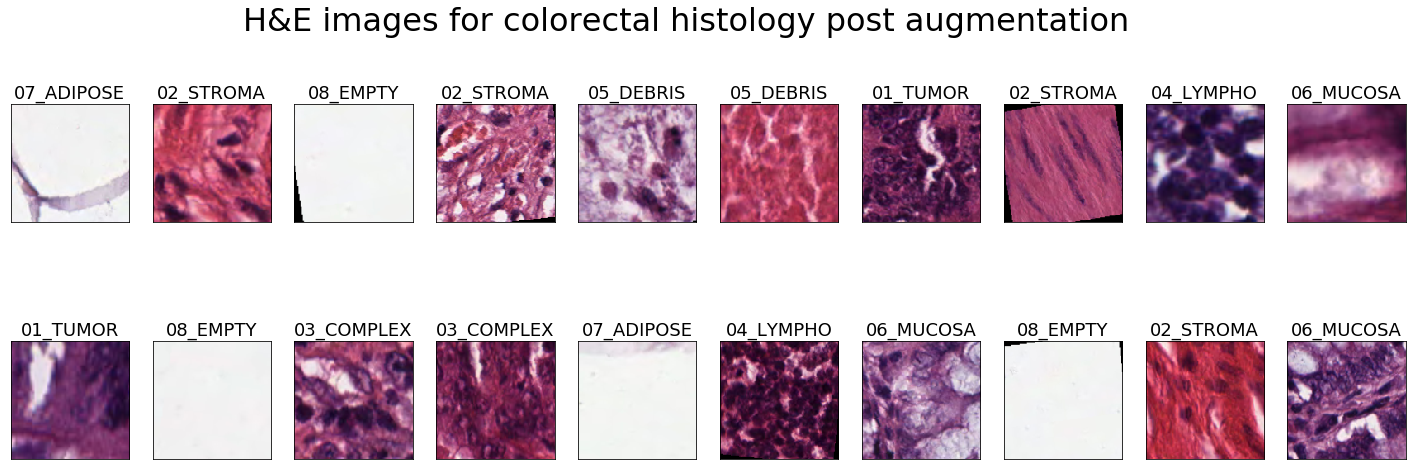

In [ ]:
def imshow_transform(img):
    '''visualize images post augmentation'''
    img = img*0.5+0.5
    plt.imshow(np.transpose(img, (1,2,0)))

images, labels = next(iter(train_loader))
images = images.numpy().squeeze()
classes = train_data.classes
palette = sns.color_palette('tab10', 8)

fig = plt.figure(figsize = (25,8))
for idx in np.arange(20):
    ax = fig.add_subplot(2,10,idx+1,xticks=[], yticks=[])
    imshow_transform(images[idx])
    ax.set_title(classes[labels.numpy()[idx]], fontsize=18)
fig.suptitle('H&E images for colorectal histology post augmentation', fontsize = 32)

'GPU' can significantly speed up the training process compared to 'CPU'. For this project, I trained the CNN model using GPU in cluster.

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('device: {}'.format(device.type))

device: cpu




we use `torchvision.datasets.ImageFolder` to load images with their path info.

reference: https://gist.github.com/andrewjong/6b02ff237533b3b2c554701fb53d5c4d

In [ ]:
class ImageFolderWithPaths(datasets.ImageFolder):
    """Custom dataset that includes image file paths. Extends
    torchvision.datasets.ImageFolder
    """

    # override the __getitem__ method. this is the method dataloader calls
    def __getitem__(self, index):
        # this is what ImageFolder normally returns 
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        # the image file path
        path = self.imgs[index][0]
        # make a new tuple that includes original and the path
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

In [ ]:
def model_eval(test_loader, model, criterion, device, classes):
    '''Apply the trained model to testing dataset and summarize the overall test_loss/test_acc
    also output testing accuracy for each category and the prediction result for each sample as well as the probability'''
    # Initiate loss and accuracy values
    test_loss = 0.0
    test_acc = 0.0
    class_correct = list(0. for i in range(len(classes)))
    class_total = list(0. for i in range(len(classes)))
  
    dt = np.dtype(int)
    true_label = np.array([], dtype = dt)
    pred_label = np.array([], dtype = dt)
    path_array = np.array([])
    prob_array = np.array([])
    probs_array = np.array(classes).reshape(1,-1)
    
    model = model.to(device)
    with torch.no_grad():
        model.eval()
        for images, labels, paths in test_loader:
            path_array = np.append(path_array, np.array(paths))
            images, labels = images.to(device), labels.to(device)
            output = model(images)
            loss = criterion(output, labels)
            test_loss += loss.item()*images.shape[0]
        
            softmax = nn.Softmax(dim=1)
            output_softmax = softmax(output)
            top_probs, preds = output_softmax.topk(1,dim=1)
            equals = preds == labels.view(*preds.shape)
            correct = np.squeeze(equals)
            test_acc += torch.mean(equals.type(torch.FloatTensor)).item()
            for i in range(len(images)):
                label = labels[i].item()
                class_correct[label] += correct[i].item()
                class_total[label] += 1
    
            if device.type == 'cpu':
                true_label = np.append(true_label, labels)
                pred_label = np.append(pred_label, preds)
                prob_array = np.append(prob_array, top_probs)
                probs_array = np.concatenate((probs_array, output_softmax))
      
            else:
                true_label = np.append(true_label, labels.cpu())
                pred_label = np.append(pred_label, preds.cpu())
                prob_array = np.append(prob_array, top_probs.cpu())
                probs_array = np.concatenate((probs_array, output_softmax.cpu()))
            
      
    test_loss = test_loss/len(test_loader.sampler)
    test_acc = test_acc/len(test_loader)
    print('Test Loss: {:.6f}\n'.format(test_loss))
    print('Test Accuracy (Overall): {:.3f}%  ({}/{})\n'.format(np.sum(class_correct)/np.sum(class_total)*100, np.sum(class_correct), np.sum(class_total)))
  
    for i in range(len(classes)):
        if class_total[i] > 0:
            print('Test Accuracy of {}: {:.3f}% ({}/{})'.format(classes[i], class_correct[i]/class_total[i]*100,class_correct[i], class_total[i]))
        else:
            print('Test Accuracy of {}: N/A'.format(classes[i]))
    summary_df = pd.DataFrame({'category': classes, 'correct': class_correct, 'total': class_total})
    pred_df = pd.DataFrame({'file_path': path_array, 'true_label': true_label, 'prediction': pred_label, 'prob': prob_array})
    probs_df = pd.DataFrame(probs_array[1:], columns = probs_array[0])
    probs_df['file_path'] = path_array
    pred_df = pred_df.merge(probs_df, left_on = 'file_path', right_on = 'file_path')
    return summary_df, pred_df

In [ ]:
cm = confusion_matrix(pred_df.true_label, pred_df.prediction)

In [ ]:
def plot_confusion_matrix(cm, classes,title='Confusion matrix',cmap=plt.cm.Blues):    
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=26)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=12, fontweight='bold')
    plt.yticks(tick_marks, classes, fontsize=12, fontweight='bold')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, '{:d} \n({:.2f}%)'.format(cm[i, j], cm[i,j]/cm.sum()*100), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=20)
    plt.xlabel('Predicted label', fontsize=20)
    plt.tight_layout()

We can use "Transfer Learning" with a ConvNet that has been pre-trained on a huge dataset (e.g. ImageNet). The new classifier with output that fits our dataset will replace the final fully-connected layer (classifier) of the pretrained model, and the remaining ConvNet will be considered as a fixed feature extractor. Only the final linear classifier is trained for the new dataset on top of the fixed feature extractor during training.

We use [Inception-v3](https://arxiv.org/pdf/1512.00567.pdf), a 42 layer deep network that uses inception modules as building blocks.

<img src="https://miro.medium.com/max/1400/1*gqKM5V-uo2sMFFPDS84yJw.png" width=600px>

Points to be noted while using Inception-v3  model:
   * **Auxiliary Classifier**: Inception-v3 has auxiliary classifier and the overall loss is caculated based on both auxiliary output and the final output. Thus, in addition to replacing the final classifier, the auxiliary classifier also needs to be replaced. 
   
   * **Input size**: Inception_v3 requires the input size to be (299,299). 

reference: 
1. https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Szegedy_Rethinking_the_Inception_CVPR_2016_paper.pdf
2. https://medium.com/@sh.tsang/review-inception-v3-1st-runner-up-image-classification-in-ilsvrc-2015-17915421f77c
3. http://cs231n.github.io/transfer-learning/
4. https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html
5. https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958

###   replacing classifiers in Inception_v3 pretrained model.

In [ ]:
inception = models.inception_v3(pretrained=True)
print(inception.AuxLogits.fc)
print(inception.fc)
for param in inception.parameters():
    param.requires_grad = False

Linear(in_features=768, out_features=1000, bias=True)
Linear(in_features=2048, out_features=1000, bias=True)


In [ ]:
## auxiliary classifier
inception.AuxLogits.fc = nn.Sequential(nn.Linear(inception.AuxLogits.fc.in_features, 8))
## final classifier
inception.fc = nn.Sequential(nn.Linear(inception.fc.in_features, 8))

###applying image transformation

In [ ]:
train_transforms = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.Resize((299,299)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [ ]:
train_data = datasets.ImageFolder(train_path, transform = train_transforms)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, sampler = train_sampler)
val_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, sampler = val_sampler)

### Training Inception_v3 model (classifiers)

* The following "train" function includes training and validation phases to avoid overfitting. The method performs a full validation step after each epoch and trains images in the training dataset for the number of provided epochs (one epoch corresponds to one cycle through the whole training dataset). 
* For both training and validation datasets, the output of the loss function and the prediction accuracy are computed after each epoch and saved as "train loss," "train acc," "val loss," and "val acc." 
* The model with the lowest 'val loss' will be kept, despite the training process going through the provided 'n epochs' of epochs., the following train function has both training and validation phases.
 
* It is important to understand how the values of "train loss," "train acc," "val loss," and "val acc" vary after each epoch in order to fine-tune hyperparameters and enhance training performance.

* The "Early Stopping" strategy can be used instead, which will cause model training to end when the provided evaluation metric (for example, accuracy on the validation set) drops or doesn't increase within a predetermined number of epochs.

In [ ]:
def train_aux(n_epochs, train_loader, val_loader, model, criterion, optimizer, device, save_path):
    '''train function specific for Inception_V3 to calcualte auxiliary output'''
    epoch_dict={}
    valid_loss_min = np.Inf
    model = model.to(device)
    for epoch in np.arange(n_epochs):
        # Initiate loss and accuracy values
        train_loss = 0.0
        train_acc = 0.0
        val_loss = 0.0
        val_acc = 0.0
        epoch_dict[epoch] = {}
        # Training
        model.train()
        for images, labels in train_loader:
            optimizer.zero_grad()
            images, labels = images.to(device), labels.to(device)
            # both final output and auxiliary output
            output, aux_output = model(images)
            loss1 = criterion(output, labels)
            loss2 = criterion(aux_output, labels)
            loss = loss1+0.4*loss2
            loss.backward()
            optimizer.step()
            ## Update loss and acc values for the training process
            train_loss += loss.item()*images.shape[0]
            _, top_class = output.topk(1,dim=1)
            equals = top_class == labels.view(*top_class.shape)
            train_acc += torch.mean(equals.type(torch.FloatTensor)).item()

        # Validation
        else:
            with torch.no_grad():
                model.eval()
                for images, labels in val_loader:
                    images, labels = images.to(device), labels.to(device)
                    output = model(images)
                    loss = criterion(output, labels)
                    ## Update loss and acc values for the validation process
                    val_loss += loss.item()*images.shape[0]
                    _, top_class = output.topk(1,dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    val_acc += torch.mean(equals.type(torch.FloatTensor)).item()

                ### write training/validation loss/accuracy
                epoch_dict[epoch]['Train_Loss'] = train_loss/len(train_loader.sampler)
                epoch_dict[epoch]['Train_Accuracy'] = train_acc/len(train_loader)
                epoch_dict[epoch]['Val_Loss'] = val_loss/len(val_loader.sampler)
                epoch_dict[epoch]['Val_Accuracy'] = val_acc/len(val_loader)

                print("Epoch: {}/{}.. ".format(epoch+1, n_epochs),
                      "Train Loss: {:.3f}.. ".format(train_loss/len(train_loader.sampler)),
                      "Train Accuracy: {:.3f}.. ".format(train_acc/len(train_loader)),
                      "Validation Loss: {:.3f}.. ".format(val_loss/len(val_loader.sampler)),
                      "Validation Accuracy: {:.3f}".format(val_acc/len(val_loader)))
                if val_loss <= valid_loss_min:
                    print('\n Validation loss decreased -- Saving model -- \n')
                    torch.save(model.state_dict(), save_path)
                    valid_loss_min = val_loss

    epoch_df = pd.DataFrame.from_dict(epoch_dict, orient = 'index')
    epoch_df['Epoch'] = np.arange(n_epochs)+1
    return model, epoch_df

In [ ]:
## Parameters from both the final classifier and the auxiliary classifier need to be trained
params = [inception.fc.parameters(), inception.AuxLogits.fc.parameters()]
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(itertools.chain(*params), lr=0.0001)

In [ ]:
n_epochs = 50
save_path = 'models/Colorectal_histology_inception_epoch50_lr4_fc1.pth'
inception, epoch_df = train_aux(n_epochs, train_loader, val_loader, inception, criterion, optimizer, device, save_path)



---



In [ ]:
epoch_df = pd.read_csv('models/Colorectal_histology_inception_epoch50_lr4_fc1.csv')

Text(0.5, 1.0, 'Training and Validation Accuracy')

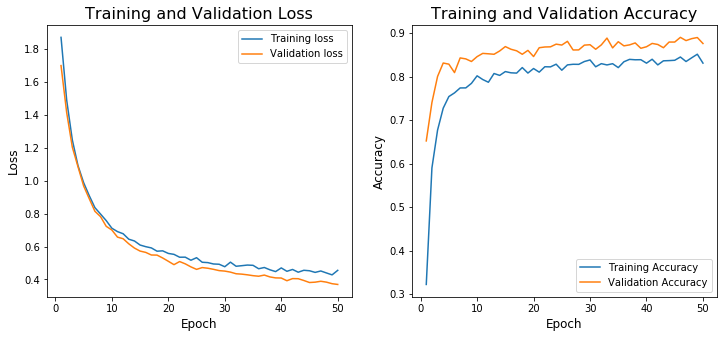

In [ ]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(epoch_df.Epoch, epoch_df.Train_Loss/1.4, label = 'Training loss')
plt.plot(epoch_df.Epoch, epoch_df.Val_Loss, label = 'Validation loss')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend()
plt.title('Training and Validation Loss', fontsize=16)

plt.subplot(1,2,2)
plt.plot(epoch_df.Epoch, epoch_df.Train_Accuracy, label = 'Training Accuracy')
plt.plot(epoch_df.Epoch, epoch_df.Val_Accuracy, label = 'Validation Accuracy')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend()
plt.title('Training and Validation Accuracy', fontsize=16)

In [ ]:
inception = models.inception_v3(pretrained=True)
inception.AuxLogits.fc = nn.Sequential(nn.Linear(inception.AuxLogits.fc.in_features, 8))
inception.fc = nn.Sequential(nn.Linear(inception.fc.in_features, 8))
if device.type == 'cpu':
    state_dict = torch.load('models/Colorectal_histology_inception_epoch50_lr4_fc1.pth', map_location='cpu')
else:
    state_dict = torch.load('models/Colorectal_histology_inception_epoch50_lr4_fc1.pth')
inception.load_state_dict(state_dict)
for param in inception.parameters():
    param.requires_grad=False

In [ ]:
## No augmentation
test_transforms = transforms.Compose([
    transforms.Resize((299,299)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
test_data = ImageFolderWithPaths(train_path, transform = test_transforms)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = BATCH_SIZE, sampler = test_sampler)
print('Number of images in testing set: {}'.format(len(test_loader.sampler)))

Number of images in testing set: 750


In [ ]:
criterion = nn.CrossEntropyLoss()
summary_df_inception, pred_df_inception = model_eval(test_loader, inception, criterion, device, classes)

Test Loss: 0.440711

Test Accuracy (Overall): 85.733%  (643.0/750.0)

Test Accuracy of 01_TUMOR: 89.773% (79.0/88.0)
Test Accuracy of 02_STROMA: 70.732% (58.0/82.0)
Test Accuracy of 03_COMPLEX: 76.842% (73.0/95.0)
Test Accuracy of 04_LYMPHO: 74.468% (70.0/94.0)
Test Accuracy of 05_DEBRIS: 89.000% (89.0/100.0)
Test Accuracy of 06_MUCOSA: 89.583% (86.0/96.0)
Test Accuracy of 07_ADIPOSE: 95.876% (93.0/97.0)
Test Accuracy of 08_EMPTY: 96.939% (95.0/98.0)


In [ ]:
summary_df_inception = pd.read_csv('models/Colorectal_histology_inception_epoch50_lr4_fc1_summary_df.csv')
pred_df_inception = pd.read_csv('models/Colorectal_histology_inception_epoch50_lr4_fc1_pred_df.csv')

Text(0.5, 1.0, 'Prediction accuracy for each tissue type by Inception_v3 model')

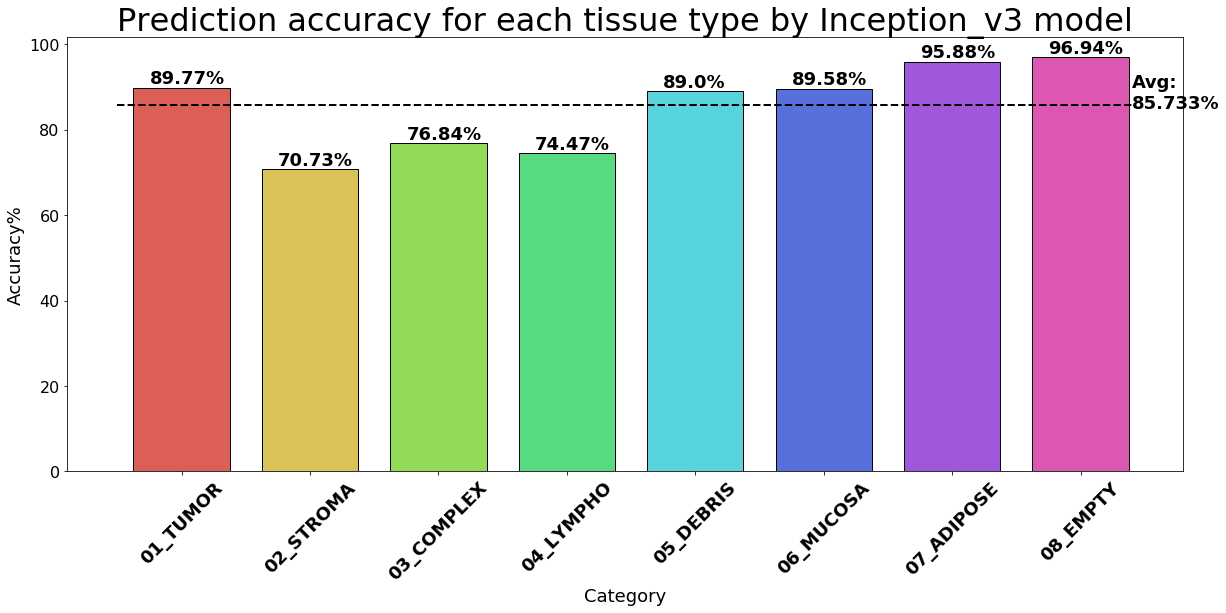

In [ ]:
summary_df_inception['accuracy'] = np.round(summary_df_inception.correct/summary_df_inception.total*100,2)
fig = plt.figure(figsize = (20,8))
ax = fig.add_subplot(1,1,1)
width = 0.75 # the width of the bars 
ind = np.arange(len(classes))  # the x locations for the groups
ax.bar(ind, summary_df_inception.accuracy, width, edgecolor='black', color = sns.color_palette('hls', 8))
plt.xticks(ind, labels = classes, fontsize=18, fontweight='bold', rotation=45)
plt.yticks(fontsize=16)
plt.xlabel('Category', fontsize=18)
plt.ylabel('Accuracy%', fontsize=18)
for i, v in enumerate(summary_df_inception.accuracy):
    ax.text(i-0.25, v + 1, str(np.round(v,2))+'%', fontweight='bold', fontsize=18)
ax.plot([-0.5, 7.4], [85.733, 85.733], "k--", linewidth=2)
ax.text(7.4, 85, 'Avg:\n'+str(85.733)+'%', fontweight='bold', fontsize=18)
plt.title('Prediction accuracy for each tissue type by Inception_v3 model', fontsize = 32)

### Confusion matrix

In [ ]:
cm_inception = confusion_matrix(pred_df_inception.true_label, pred_df_inception.prediction)

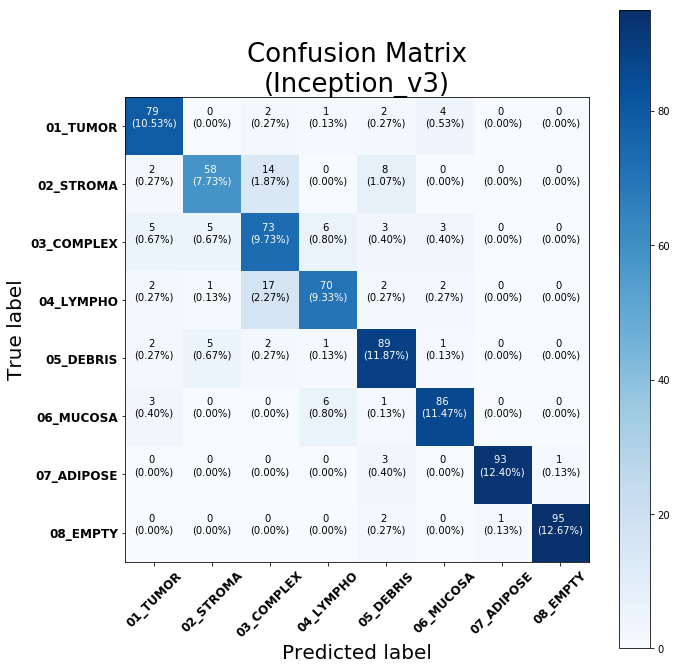

In [ ]:
plot_confusion_matrix(cm_inception, classes, title = 'Confusion Matrix\n(Inception_v3)')

### Adding another fully-connected layer before the classifer of Inception_v3

In [ ]:
inception_fc2 = models.inception_v3(pretrained=True)
for param in inception_fc2.parameters():
    param.requires_grad = False
inception_fc2.fc = nn.Sequential(nn.Linear(inception_fc2.fc.in_features, 256),
                             nn.ReLU(),
                             nn.Dropout(0.3),
                             nn.Linear(256, 8))
inception_fc2.AuxLogits.fc = nn.Sequential(nn.Linear(inception_fc2.AuxLogits.fc.in_features, 256),
                                       nn.ReLU(),
                                       nn.Dropout(0.3),
                                       nn.Linear(256, 8))

In [ ]:
## Parameters from both the final classifier and the auxiliary classifier need to be trained
params = [inception_fc2.fc.parameters(), inception_fc2.AuxLogits.fc.parameters()]
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(itertools.chain(*params), lr=0.0001)

In [ ]:
n_epochs = 50
save_path = 'models/Colorectal_histology_inception_epoch50_lr4_fc2.pth'
inception_fc2, epoch_df = train_aux(n_epochs, train_loader, val_loader, inception_fc2, criterion, optimizer, device, save_path)

In [ ]:
epoch_df = pd.read_csv('models/Colorectal_histology_inception_epoch50_lr4_fc2.csv')

Text(0.5, 1.0, 'Training and Validation Accuracy')

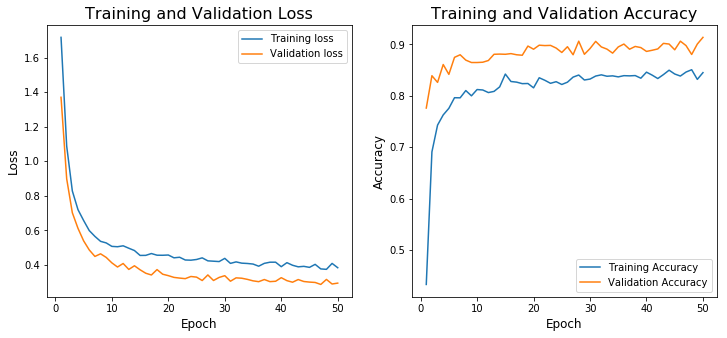

In [ ]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(epoch_df.Epoch, epoch_df.Train_Loss/1.4, label = 'Training loss')
plt.plot(epoch_df.Epoch, epoch_df.Val_Loss, label = 'Validation loss')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend()
plt.title('Training and Validation Loss', fontsize=16)

plt.subplot(1,2,2)
plt.plot(epoch_df.Epoch, epoch_df.Train_Accuracy, label = 'Training Accuracy')
plt.plot(epoch_df.Epoch, epoch_df.Val_Accuracy, label = 'Validation Accuracy')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend()
plt.title('Training and Validation Accuracy', fontsize=16)

In [ ]:
inception_fc2 = models.inception_v3(pretrained=True)
inception_fc2.fc = nn.Sequential(nn.Linear(inception_fc2.fc.in_features, 256),
                             nn.ReLU(),
                             nn.Dropout(0.3),
                             nn.Linear(256, 8))
inception_fc2.AuxLogits.fc = nn.Sequential(nn.Linear(inception_fc2.AuxLogits.fc.in_features, 256),
                                       nn.ReLU(),
                                       nn.Dropout(0.3),
                                       nn.Linear(256, 8))

if device.type == 'cpu':
    state_dict = torch.load('models/Colorectal_histology_inception_epoch50_lr4_fc2.pth', map_location='cpu')
else:
    state_dict = torch.load('models/Colorectal_histology_inception_epoch50_lr4_fc2.pth')
inception_fc2.load_state_dict(state_dict)
for param in inception_fc2.parameters():
    param.requires_grad=False

In [ ]:
## No augmentation
test_transforms = transforms.Compose([
    transforms.Resize((299,299)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
test_data = ImageFolderWithPaths(train_path, transform = test_transforms)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = BATCH_SIZE, sampler = test_sampler)
print('Number of images in testing set: {}'.format(len(test_loader.sampler)))

Number of images in testing set: 750


In [ ]:
criterion = nn.CrossEntropyLoss()
summary_df_inception_fc2, pred_df_inception_fc2 = model_eval(test_loader, inception_fc2, criterion, device, classes)

Test Loss: 0.328038

Test Accuracy (Overall): 89.867%  (674.0/750.0)

Test Accuracy of 01_TUMOR: 89.773% (79.0/88.0)
Test Accuracy of 02_STROMA: 82.927% (68.0/82.0)
Test Accuracy of 03_COMPLEX: 83.158% (79.0/95.0)
Test Accuracy of 04_LYMPHO: 84.043% (79.0/94.0)
Test Accuracy of 05_DEBRIS: 89.000% (89.0/100.0)
Test Accuracy of 06_MUCOSA: 93.750% (90.0/96.0)
Test Accuracy of 07_ADIPOSE: 94.845% (92.0/97.0)
Test Accuracy of 08_EMPTY: 100.000% (98.0/98.0)


In [ ]:
summary_df_inception_fc2 = pd.read_csv('models/Colorectal_histology_inception_epoch50_lr4_fc2_summary_df.csv')
pred_df_inception_fc2 = pd.read_csv('models/Colorectal_histology_inception_epoch50_lr4_fc2_pred_df.csv')

Text(0.5, 1.0, 'Prediction accuracy for each tissue type by Inception_v3_fc2 model')

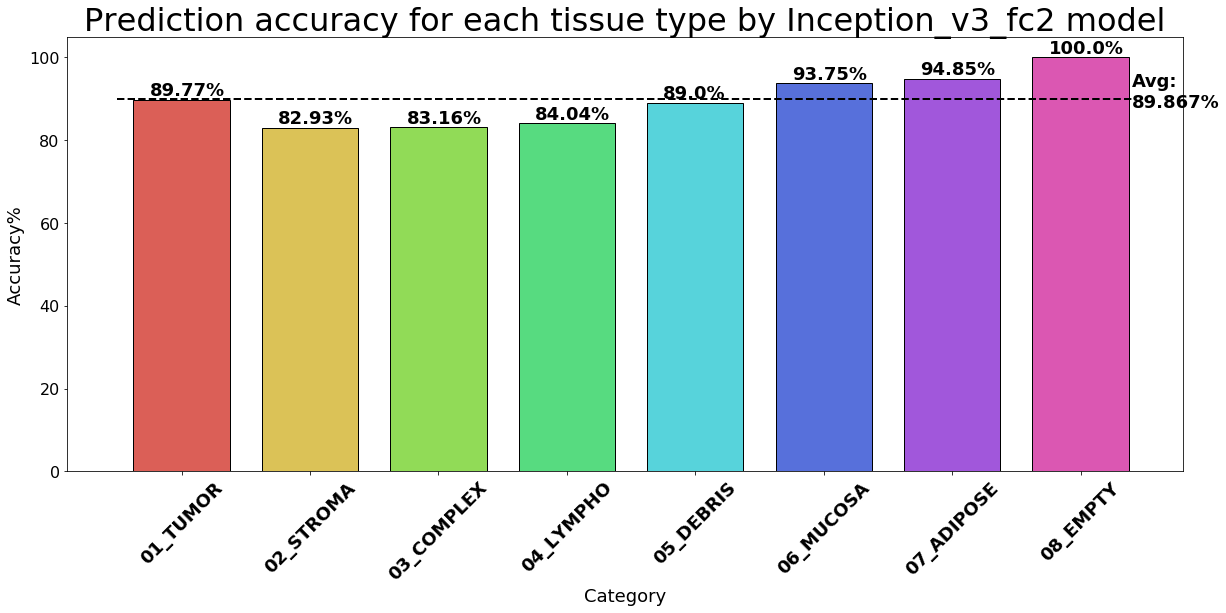

In [ ]:
summary_df_inception_fc2['accuracy'] = np.round(summary_df_inception_fc2.correct/summary_df_inception_fc2.total*100,2)
fig = plt.figure(figsize = (20,8))
ax = fig.add_subplot(1,1,1)
width = 0.75 # the width of the bars 
ind = np.arange(len(classes))  # the x locations for the groups
ax.bar(ind, summary_df_inception_fc2.accuracy, width, edgecolor='black', color = sns.color_palette('hls', 8))
plt.xticks(ind, labels = classes, fontsize=18, fontweight='bold', rotation=45)
plt.yticks(fontsize=16)
plt.xlabel('Category', fontsize=18)
plt.ylabel('Accuracy%', fontsize=18)
for i, v in enumerate(summary_df_inception_fc2.accuracy):
    ax.text(i-0.25, v + 1, str(np.round(v,2))+'%', fontweight='bold', fontsize=18)
ax.plot([-0.5, 7.4], [89.867, 89.867], "k--", linewidth=2)
ax.text(7.4, 88, 'Avg:\n'+str(89.867)+'%', fontweight='bold', fontsize=18)
plt.title('Prediction accuracy for each tissue type by Inception_v3_fc2 model', fontsize = 32)

#### Confusion matrix

In [ ]:
cm_inception_fc2 = confusion_matrix(pred_df_inception_fc2.true_label, pred_df_inception_fc2.prediction)

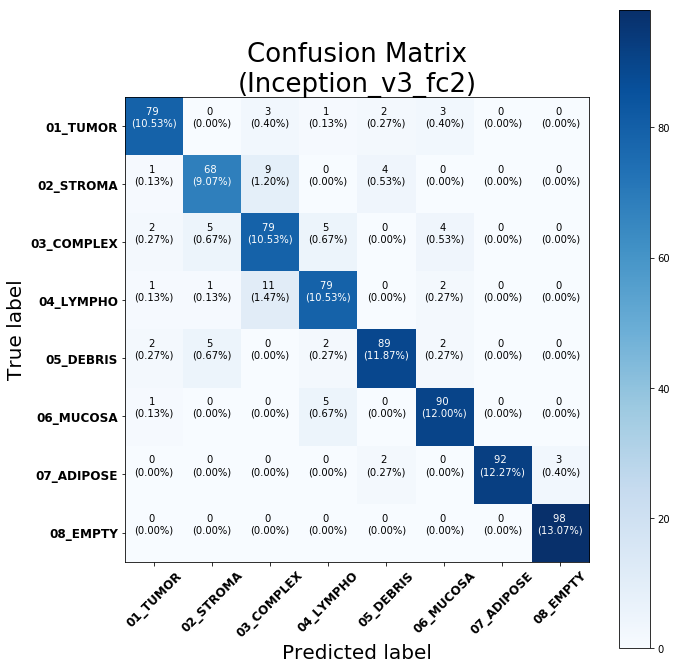

In [ ]:
plot_confusion_matrix(cm_inception_fc2, classes, title = 'Confusion Matrix\n(Inception_v3_fc2)')

#### ROC curve

In [ ]:
from sklearn.metrics import roc_curve, auc
fpr = dict()
tpr = dict()
auc_list = []
label_to_class_dict = {i:l for i,l in enumerate(classes)}
for i in np.arange(len(classes)):
    true_label_array = (pred_df_inception_fc2.true_label == i)*1
    probs = pred_df_inception_fc2[label_to_class_dict[i]]
    fpr[i], tpr[i], _ = roc_curve(true_label_array, probs)
    auc_value = auc(fpr[i], tpr[i])
    auc_list.append(auc_value)

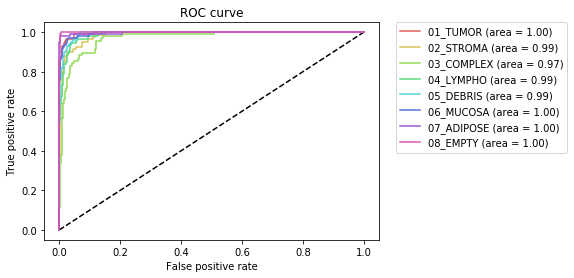

In [ ]:
palette = sns.color_palette('hls', 8)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
for i in np.arange(len(classes)):
    plt.plot(fpr[i], tpr[i], color = palette[i], label='{} (area = {:.2f})'''.format(classes[i], auc_list[i]))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

### View classification results for a panel of randomly selected images from test dataset

In [ ]:
def plot_image(i, paths, labels_array, ps_darray, classes):
    img_path = paths[i]
    plt.imshow(readImage_rgb(img_path))
    plt.xticks([])
    plt.yticks([])
    
    pred = np.argmax(ps_darray[i])
    if pred == labels_array[i]:
        color = 'blue'
    else:
        color = 'red'
    plt.xlabel('pred: {} ({:.2f}%)\ntrue_label: {}'.format(classes[pred], np.max(ps_darray[i])*100, classes[labels_array[i]]), color = color)

def plot_classification(i, labels_array, ps_darray, classes):
    thisplot = plt.barh(np.arange(len(classes)), ps_darray[i], color = '#777777')
    plt.yticks(np.arange(len(classes)), classes)
    plt.xlim(0,1)
    plt.xlabel('probability')
    plt.ylabel('classes')
    pred = np.argmax(ps_darray[i])
    thisplot[pred].set_color('red')
    thisplot[labels_array[i]].set_color('blue')

In [ ]:
images, labels, paths = next(iter(test_loader))
with torch.no_grad():
    inception_fc2.eval()
    output = inception_fc2(images)
    softmax = nn.Softmax(dim=1)
    ps = softmax(output)
    labels_array = labels.numpy().squeeze()
    ps_darray = ps.numpy().squeeze()

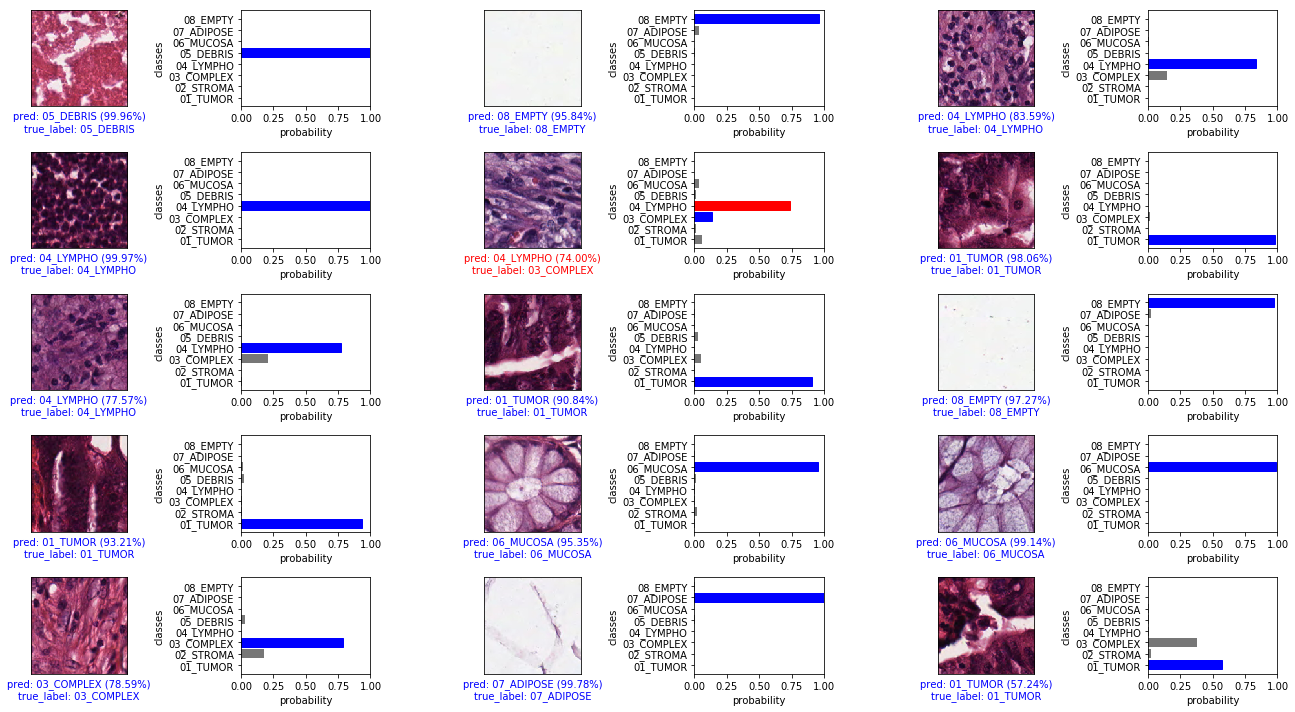

In [ ]:
## viewing  a panel of images in the testing set
num_rows = 5
num_cols = 3
plt.figure(figsize=(3*2*num_cols,2*num_rows))
for i in np.arange(15):
    plt.subplot(num_rows, num_cols*2, 2*i+1)
    plot_image(i, paths, labels_array, ps_darray, classes)
    plt.subplot(num_rows, num_cols*2, 2*i+2)
    plot_classification(i, labels_array, ps_darray, classes)
plt.tight_layout()

**Conclusion**: It is possible to get an overall accuracy of 89.867% across 8 different tissue types by using pretrained Inception v3 (convolutional component), adding and training a fully-connected layer with 256 nodes, and training the final classifier for H&E images in this dataset:

  * 0: `01_TUMOR` -- 89.77%
  
  * 1: `02_STROMA` -- 82.93%
  
  * 2: `03_COMPLEX` -- 83.16%
  
  * 3: `04_LYMPHO` -- 84.04%
  
  * 4: `05_DEBRIS` -- 89.00%
  
  * 5: `06_MUCOSA` -- 93.75%
  
  * 6: `07_ADIPOSE` -- 94.85%
  
  * 7: `08_EMPTY` -- 100.00%


1.The model is very good at classifying classes that show a distinct pixel distribution pattern such as ADIPOSE and EMPTY. 


2.The prediction accuracy for STROMA and COMPLEX classes is relatively low and based on the confusion matrix, a large proportion of misclassified images in these two classes fall into the other class. 

3.Considering the definition of STROMA and COMPLEX classes (both are stroma), it's understandable that it's difficult to classify between these two classes.
